# Compute the number of generations since admixture from admixture tract lengths

In [1]:
import numpy as np
import patsy as ps
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set()
sns.set_style('ticks')

### Generate some dummy exponentially distributed length data

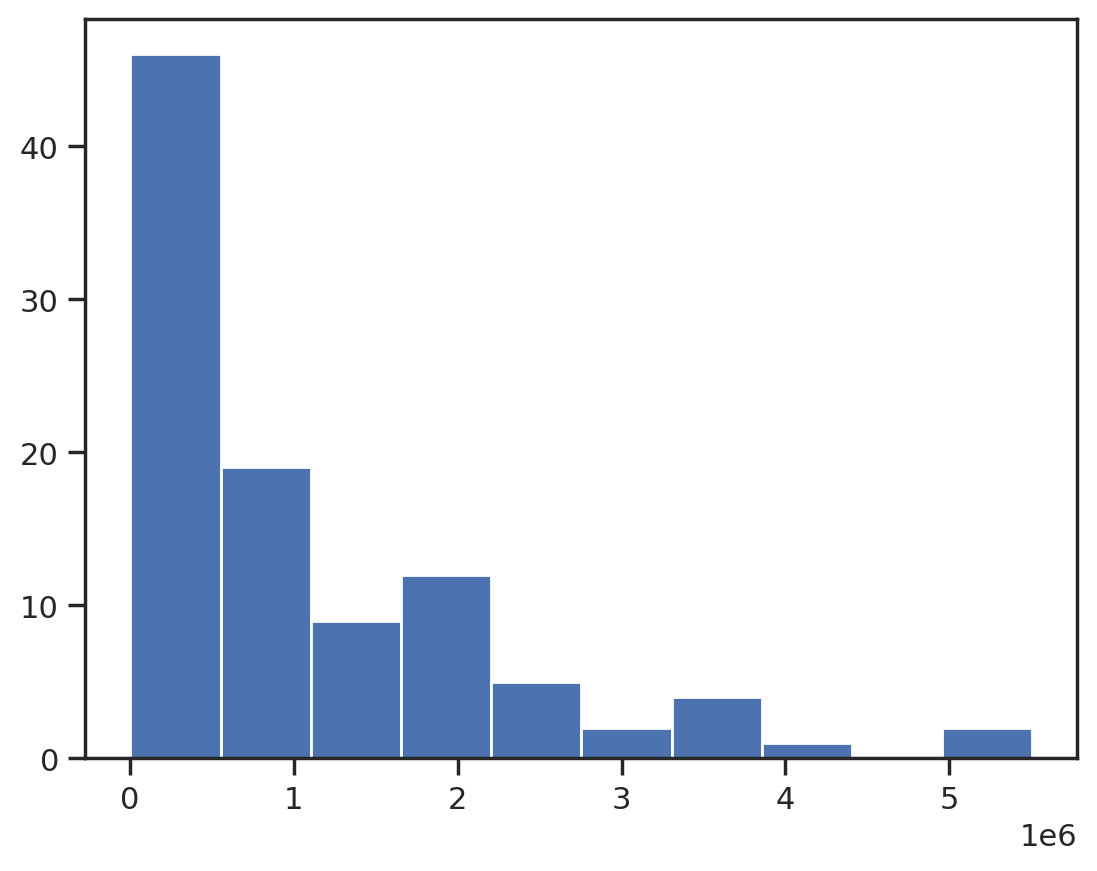

In [2]:
# dummy length data
from numpy.random import exponential
phys_lengths = exponential(scale=1000000, size=100) #+ 1000000000
plt.hist(phys_lengths) ;

In [3]:
mean_rec_rate = 1e-8
lengths = phys_lengths * mean_rec_rate

### Compute the empirical CDF

In [4]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

val, prob = ecdf(lengths)

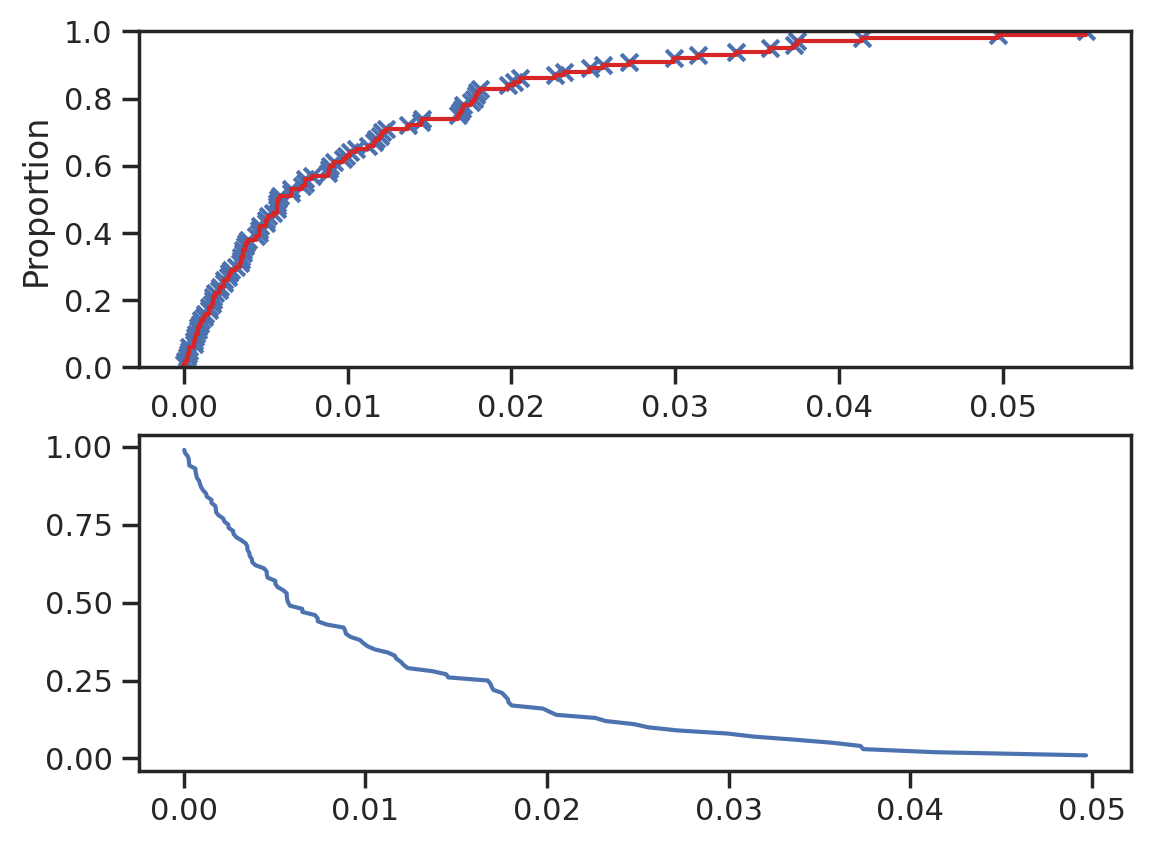

In [5]:
plt.subplot(211)
plt.scatter(val, prob, marker='x')
# sanity check
sns.ecdfplot(x=val, color='tab:red') 

# PDF
plt.subplot(212)
d, p = val[:-1], 1-prob[:-1] # leave out last one to avoid division by zero
plt.plot(d, p) ;

### Estimate the number of generations

The admixture is likely not the result of a single admixture event, but if we assume that it is, the length distribution of tracts is well approximated by $y=Ae^{−(n−1)d}$. Here $n$ is the number of generations since the admixture event and $d$ is genetic distance (physical length times mean recombination rate per base) and $A$ is a scaling factor. We fit a line to the log of the complementary cummulative distribution (the PDF) of tract lengths and, since $\ln(y)=−(n−1)d+\ln(A)$, the slope of the fitted line is n−1.

Intercept    -0.091038
d           -87.118639
dtype: float64

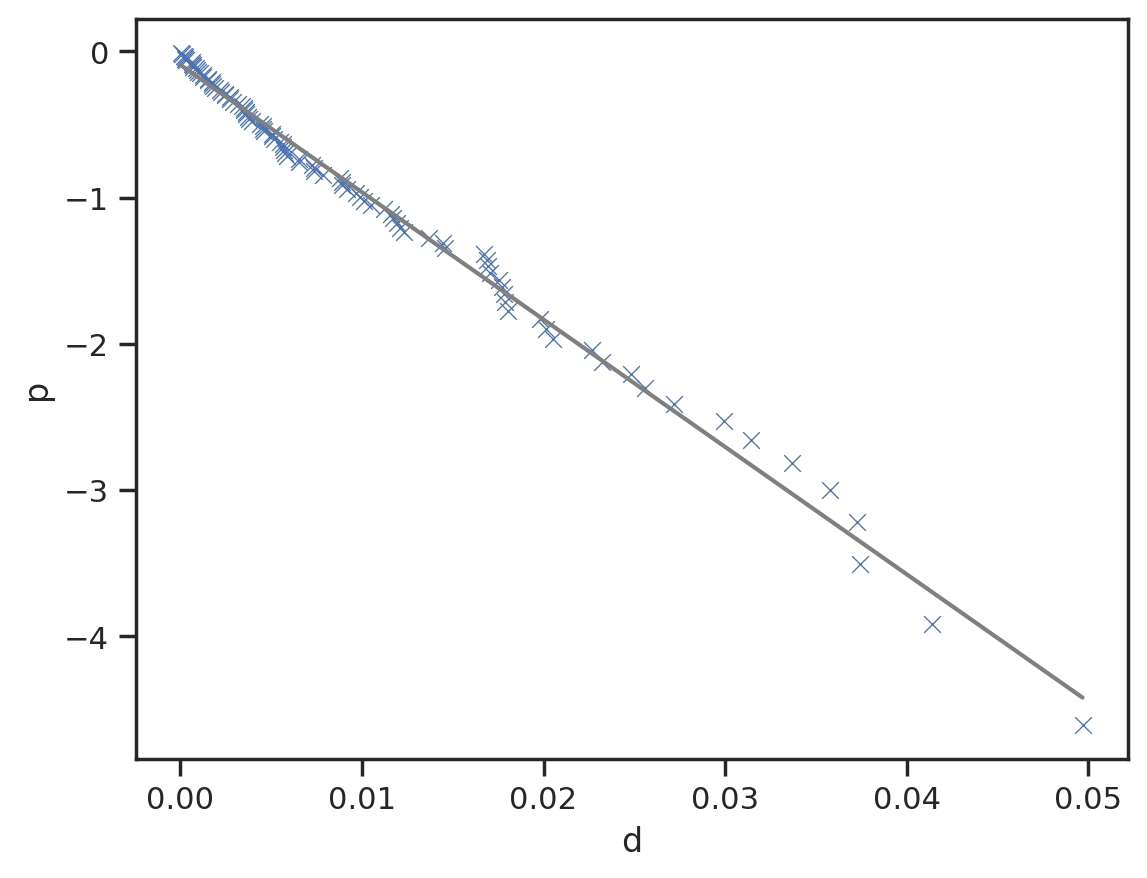

In [6]:
# mask = ~np.isnan(x)
# df = pd.DataFrame(dict(d=d[mask], p=np.log(1-p[mask])))

df = pd.DataFrame(dict(d=d, p=np.log(p)))

y, X = ps.dmatrices('p ~ d',data = df, return_type = 'dataframe')
model = sm.OLS(y,X)
results = model.fit()
predicted_p = results.predict()
p_residuals = df.p - predicted_p

ax = sns.scatterplot(x=df.d, y=df.p, marker='x');
ax.plot(df.d, predicted_p, color='grey', marker=None);
results.params

Generations since admixture pulse is:

In [7]:
round(-results.params.d + 1)

88

Loading in data for Tanzania and Ethiopia

In [8]:
def create_paint_df_ind_compressed(df, ind, mapping, ns_map):
    d = {}
    max_pos = int(df.epos.iloc[-1])
    df = df.loc[df[ind].shift() != df[ind]].reset_index()
    df["epos"] = pd.concat([df.spos.iloc[1:], pd.Series(max_pos)], ignore_index=True)
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Kindae, Zambia': 0,
 'Papio, Senegal': 1,
 'Ursinus, Zambia': 0}

df_l = []
for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind_compressed(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)
df_l = []
for c in ["chr{}".format(x) for x in (range(1, 21))] + ["chrX"]:
    genetic_map = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/mikumi_pyrho_genetic_map_{}.txt"
    chr_recomb = pd.read_csv(genetic_map.format(c), sep=" ")
    df_l.append(chr_recomb)
recomb_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [9]:
df_l = []
for c in length_df.chrom.unique():
    print(c)
    
    l_df = length_df.loc[length_df.chrom == c].copy()
    if c == "female_chrX" or c == "all_chrX":
        c = "chrX"
    r_df = recomb_df.loc[(recomb_df.chromosome == c)]
    pos_mapping = dict(zip(r_df.position, r_df["Genetic_Map(cM)"]))
    l_df["start_cM"] = l_df.pos.map(pos_mapping)
    l_df["end"] = l_df.end_pos + 1
    l_df["end_cM"] = l_df.end.map(pos_mapping)
    df_l.append(l_df)
df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [10]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Cynocephalus, Central Tanzania': 0,
 'Papio, Senegal': 0,
 'Anubis, Tanzania': 0}

df_l = []
for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind_compressed(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [11]:
df_l = []
for c in length_df.chrom.unique():
    print(c)
    
    l_df = length_df.loc[length_df.chrom == c].copy()
    if c == "female_chrX" or c == "all_chrX":
        c = "chrX"
    r_df = recomb_df.loc[(recomb_df.chromosome == c)]
    pos_mapping = dict(zip(r_df.position, r_df["Genetic_Map(cM)"]))
    l_df["start_cM"] = l_df.pos.map(pos_mapping)
    l_df["end"] = l_df.end_pos + 1
    l_df["end_cM"] = l_df.end.map(pos_mapping)
    df_l.append(l_df)
df_eth = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [12]:
meta_data_samples_sci = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")

df["Species"] = df.individual.map(dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Species)))
df["Origin"] = df.individual.map(dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Origin)))

df_eth["Species"] = df_eth.individual.map(dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Species)))
df_eth["Origin"] = df_eth.individual.map(dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Origin+"_eth_case")))
length_df_tanz_eth = pd.concat([df, df_eth])

In [13]:
length_df_tanz_eth

,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,start_cM,end,end_cM,Species,Origin
0,160,9915383,9915224,"Kindae, Zambia",0,Sci_16066,0,chr1,0.000057,9915384,13.556968,cynocephalus,"Mikumi, Tanzania"
1,9915384,10291147,375764,"Hamadryas, Ethiopia",1,Sci_16066,0,chr1,13.556968,10291148,13.916870,cynocephalus,"Mikumi, Tanzania"
2,10291148,33224041,22932894,"Kindae, Zambia",0,Sci_16066,0,chr1,13.916870,33224042,43.207802,cynocephalus,"Mikumi, Tanzania"
3,33224042,33578534,354493,"Hamadryas, Ethiopia",1,Sci_16066,0,chr1,43.207802,33578535,43.351891,cynocephalus,"Mikumi, Tanzania"
4,33578535,39239117,5660583,"Kindae, Zambia",0,Sci_16066,0,chr1,43.351891,39239118,47.063374,cynocephalus,"Mikumi, Tanzania"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,91954355,92441774,487420,"Cynocephalus, Central Tanzania",0,PD_0792,1,female_chrX,82.557416,92441775,82.984241,kindae,"Chunga, Zambia_eth_case"
29,92441775,92824755,382981,"Hamadryas, Ethiopia",1,PD_0792,1,female_chrX,82.984241,92824756,83.935652,kindae,"Chunga, Zambia_eth_case"
30,92824756,94470854,1646099,"Cynocephalus, Central Tanzania",0,PD_0792,1,female_chrX,83.935652,94470855,84.850342,kindae,"Chunga, Zambia_eth_case"
31,94470855,95908432,1437578,"Hamadryas, Ethiopia",1,PD_0792,1,female_chrX,84.850342,95908433,85.704730,kindae,"Chunga, Zambia_eth_case"


In [14]:
#Selecting the cases of interest and setting Minor Parent Ancestry
origins_interest = ['Arusha, Tanzania',
       'Gog Woreda, Gambella region, Ethiopia',
       'Gog Woreda, Gambella region, Ethiopia_eth_case',
       'Gombe, Tanzania', 'Issa Valley, Tanzania',
       'Katavi, Tanzania','Lake Manyara, Tanzania',
       'Mahale, Tanzania',
       'Mikumi, Tanzania', 'Ngorongoro, Tanzania', 'Ruaha, Tanzania',
       'Selous, Tanzania', 'Serengeti, Tanzania', 'Tarangire, Tanzania',
       'Udzungwa, Tanzania']
length_df_tanz_eth = length_df_tanz_eth.loc[length_df_tanz_eth.Origin.isin(origins_interest)]
length_df_tanz_eth["minor_parent_percentage"] = [x if y == ("cynocephalus") or z == "Gog Woreda, Gambella region, Ethiopia_eth_case"
                                             else 1-x for x, y, z in zip(length_df_tanz_eth["n/s"],
                                                                         length_df_tanz_eth["Species"],
                                                                        length_df_tanz_eth["Origin"])]
length_df_tanz_eth["cM_length"] = length_df_tanz_eth.end_cM-length_df_tanz_eth.start_cM

/tmp/48080740/ipykernel_1493253/2485582720.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  length_df_tanz_eth["minor_parent_percentage"] = [x if y == ("cynocephalus") or z == "Gog Woreda, Gambella region, Ethiopia_eth_case"
/tmp/48080740/ipykernel_1493253/2485582720.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  length_df_tanz_eth["cM_length"] = length_df_tanz_eth.end_cM-length_df_tanz_eth.start_cM


In [15]:
length_df_tanz_eth.loc[length_df_tanz_eth.minor_parent_percentage == 1]

,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,start_cM,end,end_cM,Species,Origin,minor_parent_percentage,cM_length
1,9915384,10291147,375764,"Hamadryas, Ethiopia",1,Sci_16066,0,chr1,13.556968,10291148,13.916870,cynocephalus,"Mikumi, Tanzania",1,0.359901
3,33224042,33578534,354493,"Hamadryas, Ethiopia",1,Sci_16066,0,chr1,43.207802,33578535,43.351891,cynocephalus,"Mikumi, Tanzania",1,0.144089
47,214850280,214970250,119971,"Hamadryas, Ethiopia",1,Sci_16066,0,chr1,168.300748,214970251,168.446887,cynocephalus,"Mikumi, Tanzania",1,0.146139
1,7037733,7672850,635118,"Hamadryas, Ethiopia",1,Sci_16066,1,chr1,10.377503,7672851,10.888662,cynocephalus,"Mikumi, Tanzania",1,0.511159
3,9915384,10291147,375764,"Hamadryas, Ethiopia",1,Sci_16066,1,chr1,13.556968,10291148,13.916870,cynocephalus,"Mikumi, Tanzania",1,0.359901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,134272891,134703012,430122,"Hamadryas, Ethiopia",1,PD_0744,1,female_chrX,121.647302,134703013,122.002305,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,0.355003
130,134821453,135373119,551667,"Hamadryas, Ethiopia",1,PD_0744,1,female_chrX,122.097994,135373120,122.658891,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,0.560897
132,135612557,137015917,1403361,"Hamadryas, Ethiopia",1,PD_0744,1,female_chrX,122.873780,137015918,123.208238,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,0.334458
134,137227765,138106760,878996,"Hamadryas, Ethiopia",1,PD_0744,1,female_chrX,123.231057,138106761,123.785145,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,0.554088


In [16]:
length_df_tanz_eth.loc[length_df_tanz_eth.minor_parent_percentage == 1].groupby(["individual", "chrom"])["length"].median().reset_index()

,individual,chrom,length
0,PD_0199,all_chrX,106411.0
1,PD_0199,chr1,294766.0
2,PD_0199,chr10,132348.0
3,PD_0199,chr11,175058.0
4,PD_0199,chr12,208251.0
...,...,...,...
3291,Sci_16098,chr6,297640.0
3292,Sci_16098,chr7,296532.5
3293,Sci_16098,chr8,246770.5
3294,Sci_16098,chr9,198374.0


In [17]:
length_sum = length_df_tanz_eth.loc[length_df_tanz_eth.minor_parent_percentage == 1].groupby(["individual", "chrom"])["length"].sum().reset_index()
length_median = length_df_tanz_eth.loc[length_df_tanz_eth.minor_parent_percentage == 1].groupby(["individual", "chrom"])["length"].median().reset_index()
length_df = length_df_tanz_eth.groupby(["individual", "chrom"])["length"].sum().reset_index()
length_df = length_df.merge(length_sum, on=["individual","chrom"])
length_df = length_df.merge(length_median, on=["individual","chrom"])

In [18]:
length_df["Admix Proportion"] = length_df.length_y/length_df.length_x
length_df["Median Fragment"] = length_df.length

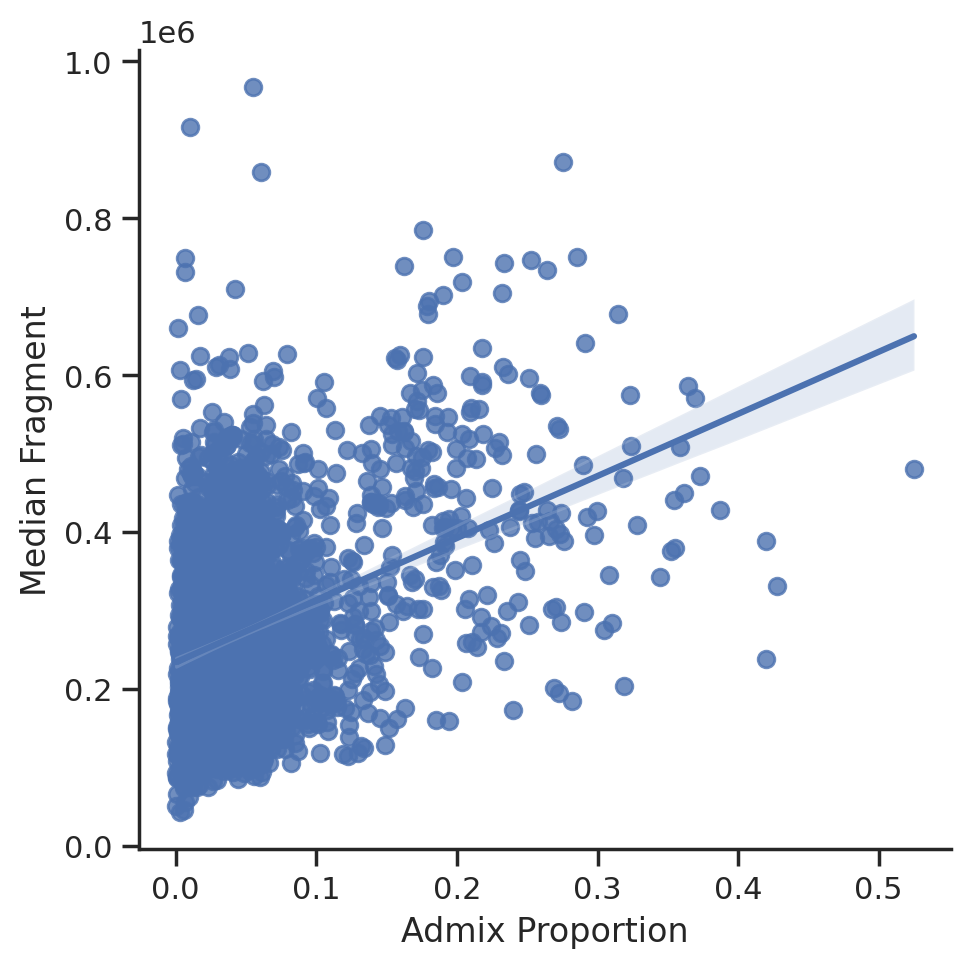

In [19]:
sns.lmplot(length_df, x="Admix Proportion", y="Median Fragment")

In [16]:
length_df_tanz_eth.loc[length_df_tanz_eth.individual == "Sci_16066"].cM_length.sum()/200

25.434585214173193

In [17]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

origin_l, date_l, morgan_l = [], [], []

for o in length_df_tanz_eth.Origin.unique():
    print(o)
    s_df = length_df_tanz_eth.loc[length_df_tanz_eth.Origin == o]
    for ID in s_df.individual.unique():
        print(ID)
        ss_df = s_df.loc[(s_df.individual == ID) & (s_df["minor_parent_percentage"] == 1) &
                        (s_df.cM_length > 0.1) &
                         ~(s_df.chrom).isin(["all_chrX", "female_chrX"])]
        lengths = ss_df.cM_length/100
        val, prob = ecdf(lengths.sort_values(ascending=False).iloc[:len(lengths)//5])
        d, p = val[:-1], 1-prob[:-1]
        m_df = pd.DataFrame(dict(d=d, p=np.log(p)))

        y, X = ps.dmatrices('p ~ d',data = m_df, return_type = 'dataframe')
        model = sm.GLM(y,X, var_weights=X.d)
        results = model.fit()
        predicted_p = results.predict()
        p_residuals = m_df.p - predicted_p
        print(round(-results.params.d + 1), lengths.mean(), lengths.median(), lengths.sum())
        origin_l.append(o), date_l.append(-results.params.d + 1), morgan_l.append(lengths.sum())

Mikumi, Tanzania
Sci_16066
250 0.0029495448393566928 0.0023189228413153804 0.6312025956223323
Sci_16098
285 0.002927308780898813 0.002164690529071329 0.532770198123584
PD_0268
215 0.003390702860690251 0.002397631487947223 0.7357825207697845
PD_0269
415 0.0028051036965383463 0.002148320147345508 0.5329697023422858
PD_0270
583 0.0029467709500385973 0.0022520818843119626 0.5657800224074107
PD_0271
227 0.0033926037486584908 0.0023743601880000754 0.6310242972504793
PD_0272
175 0.003262860073273772 0.0023609196347582893 0.48616615091779203
PD_0637
209 0.0028447712749884346 0.0022746744905899163 0.543351313522791
PD_0687
158 0.003269904403966805 0.0021707369947478127 0.5885827927140249
PD_0688
324 0.003264486045983233 0.002377420806928896 0.587607488276982
PD_0689
154 0.0036949952345004078 0.0024689015140970127 0.7574740230725836
PD_0690
160 0.0033436612810851165 0.0022633462362822423 0.5483604500979591
PD_0691
240 0.0032013496723203674 0.002346268480207243 0.6882901795488789
PD_0745
135 0.00

PD_0662
91 0.005915817233198274 0.0037151266058231157 15.091249761888799
Gog Woreda, Gambella region, Ethiopia
PD_0720
194 0.00723615460627937 0.0036569627490849756 0.13025078291302866
PD_0721
50 0.005497748821859012 0.0021041294137942044 0.0989594787934622
PD_0722
311 0.007277395457062569 0.004440588896784643 0.14554790914125137
PD_0723
106 0.006309529020179444 0.003353272016295783 0.18928587060538332
PD_0724
1730 0.00784290848763776 0.003568740818539915 0.18038689521566847
PD_0725
128 0.004817265315467158 0.0028075507307784163 0.11079710225574463
PD_0726
1342 0.006900202551311394 0.004530033806594532 0.19320567143671905
PD_0727
163 0.003264597451157576 0.0023332493362767078 0.05876275412083636
PD_0728
2589 0.0037146127339203676 0.003748338699448297 0.07800686741232772
PD_0729
1474 0.004561479730641396 0.0037226856705470015 0.09122959461282791
PD_0730
1464 0.008976101999242618 0.0041974141701837595 0.19747424398333757
PD_0731
1394 0.009526966522513973 0.005106790658065705 0.2095932634

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:813: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  scale = np.dot(wresid, wresid) / df_resid
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:813: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/hom

67 0.004753263247240821 0.002229074107662754 0.13784463416998383
PD_0743
123 0.005438880958460532 0.0029518160782817304 0.1522886668368949
PD_0744
108 0.0070615049152212795 0.0035184539773271874 0.21184514745663838
Gog Woreda, Gambella region, Ethiopia_eth_case
PD_0720
115 0.005140688205947863 0.003364825876965938 4.842528290002887
PD_0721
138 0.0049040584723500855 0.003351904804689525 4.408748566642727
PD_0722
141 0.004907831323784747 0.003455419077169415 4.377785540815994
PD_0723
117 0.004553858406009587 0.0032531442422255807 4.235088317588916
PD_0724
137 0.0049659088280840135 0.0033945351116048527 4.633192936602384
PD_0725
117 0.004806304354901788 0.003234001723783719 4.450637832639055
PD_0726
137 0.004783638488053723 0.003414768370789858 4.5683747560913055
PD_0727
93 0.005031067349782602 0.003210810285266561 4.67889263529782
PD_0728
110 0.005057915796049398 0.0032691336385676094 4.70891960612199
PD_0729
135 0.004863916259046756 0.003302394455289637 4.499122539618249
PD_0730
115 0.0

In [18]:
date_df = pd.DataFrame({"Origin": origin_l, "Date": date_l, "Morgan_admixture": morgan_l})
date_df["log_date"] = np.log(date_df.Date)

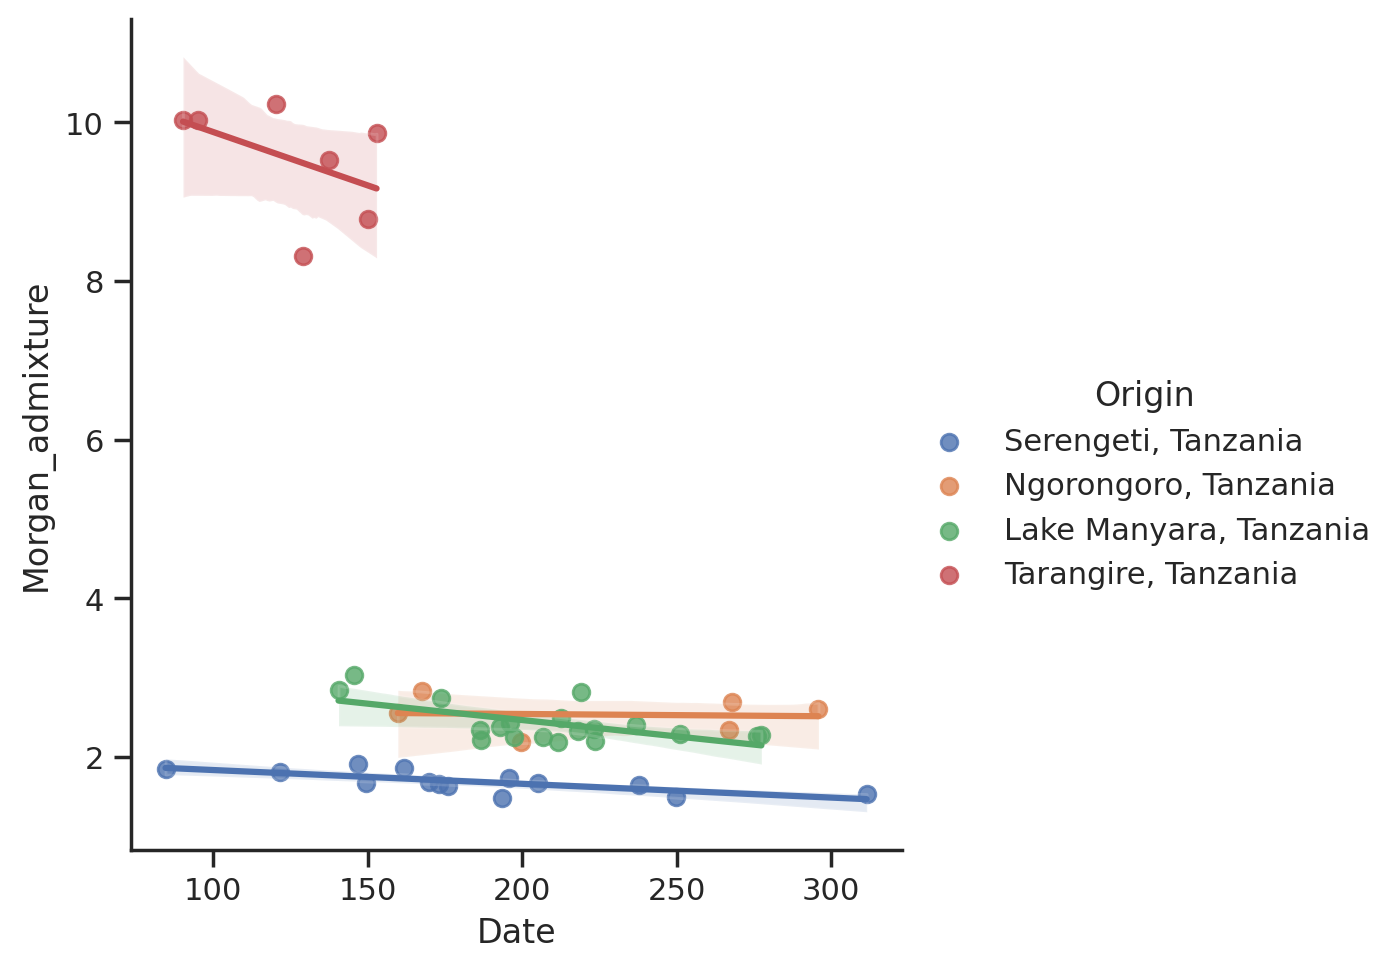

In [19]:
sns.lmplot(data=date_df.loc[date_df.Origin.isin(["Serengeti, Tanzania",
                                                 "Tarangire, Tanzania",
                                                "Lake Manyara, Tanzania",
                                                "Ngorongoro, Tanzania"])], 
           x="Date", y="Morgan_admixture", hue="Origin")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


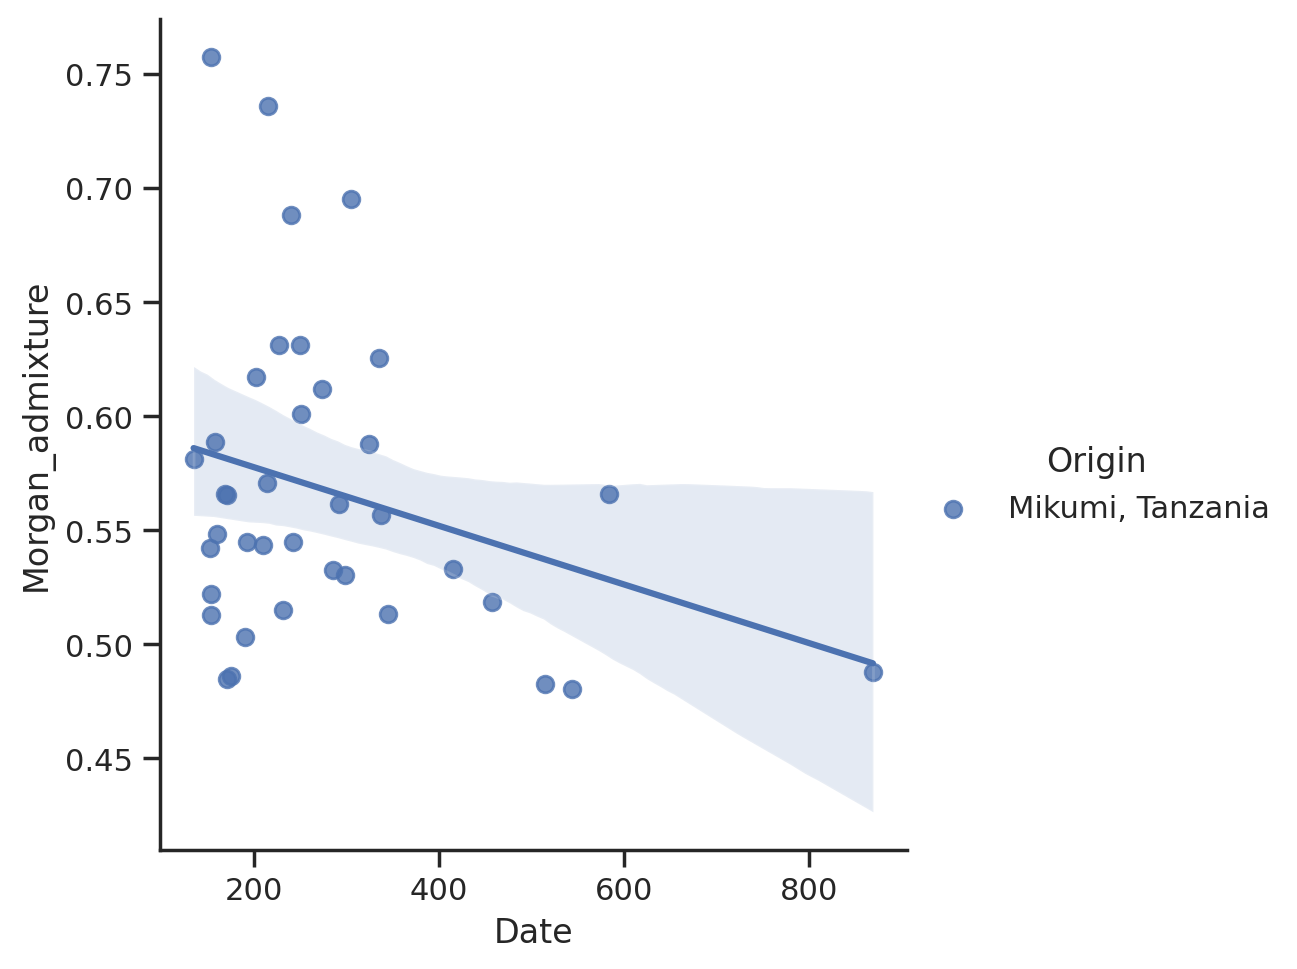

<Figure size 640x480 with 0 Axes>

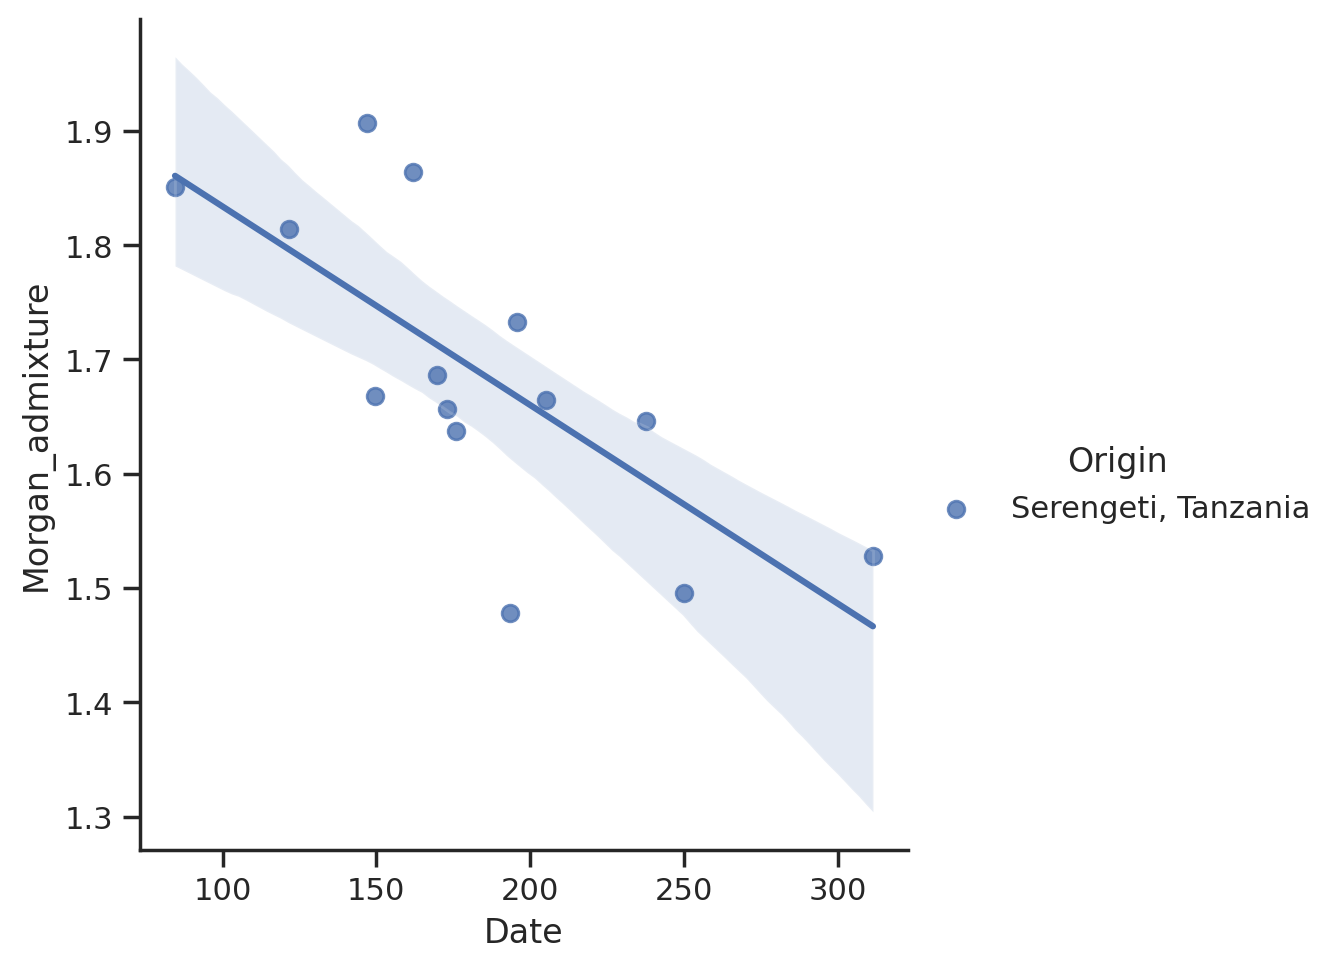

<Figure size 640x480 with 0 Axes>

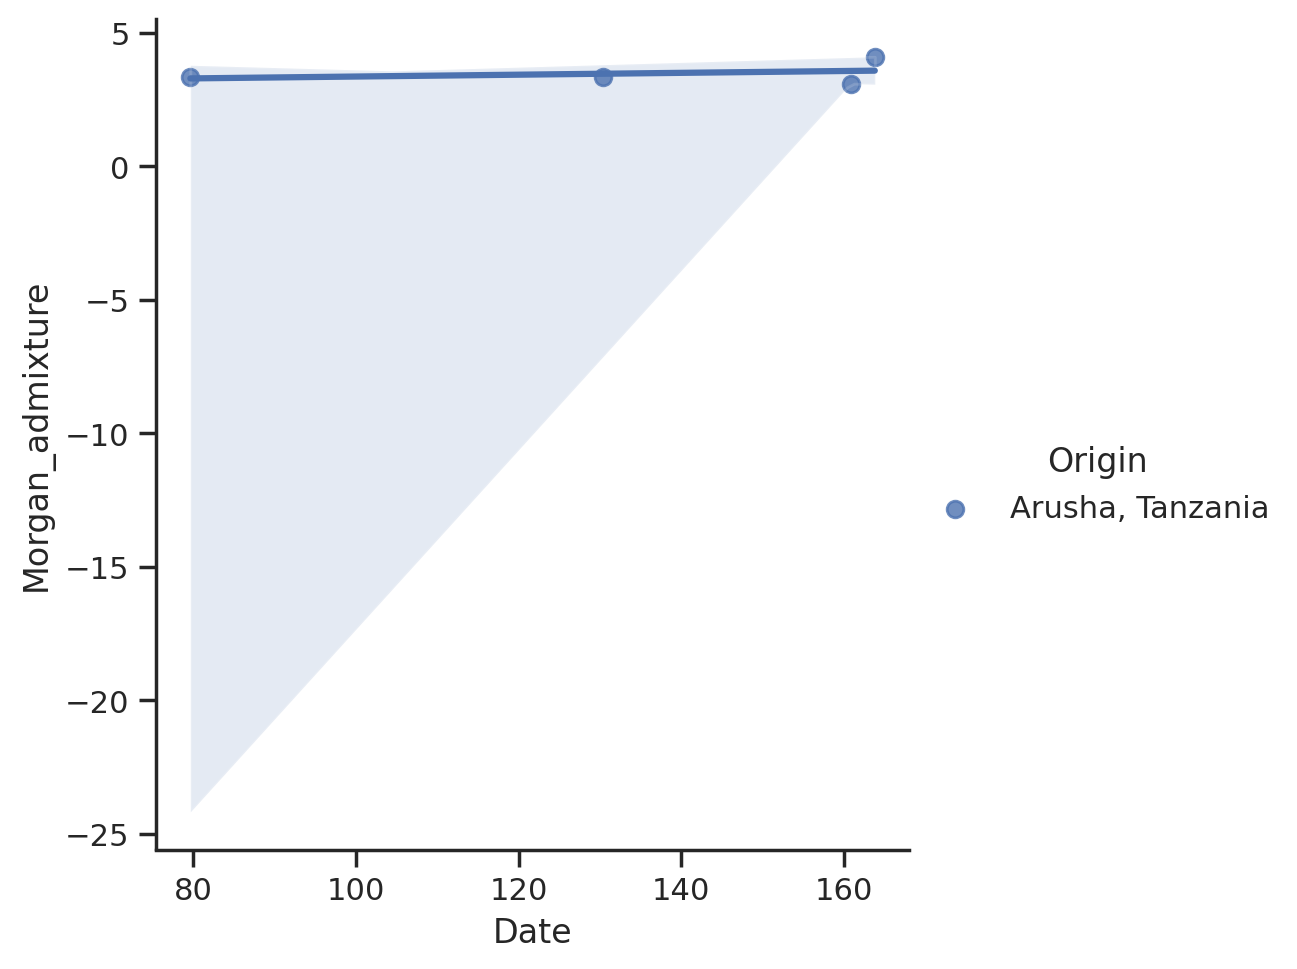

<Figure size 640x480 with 0 Axes>

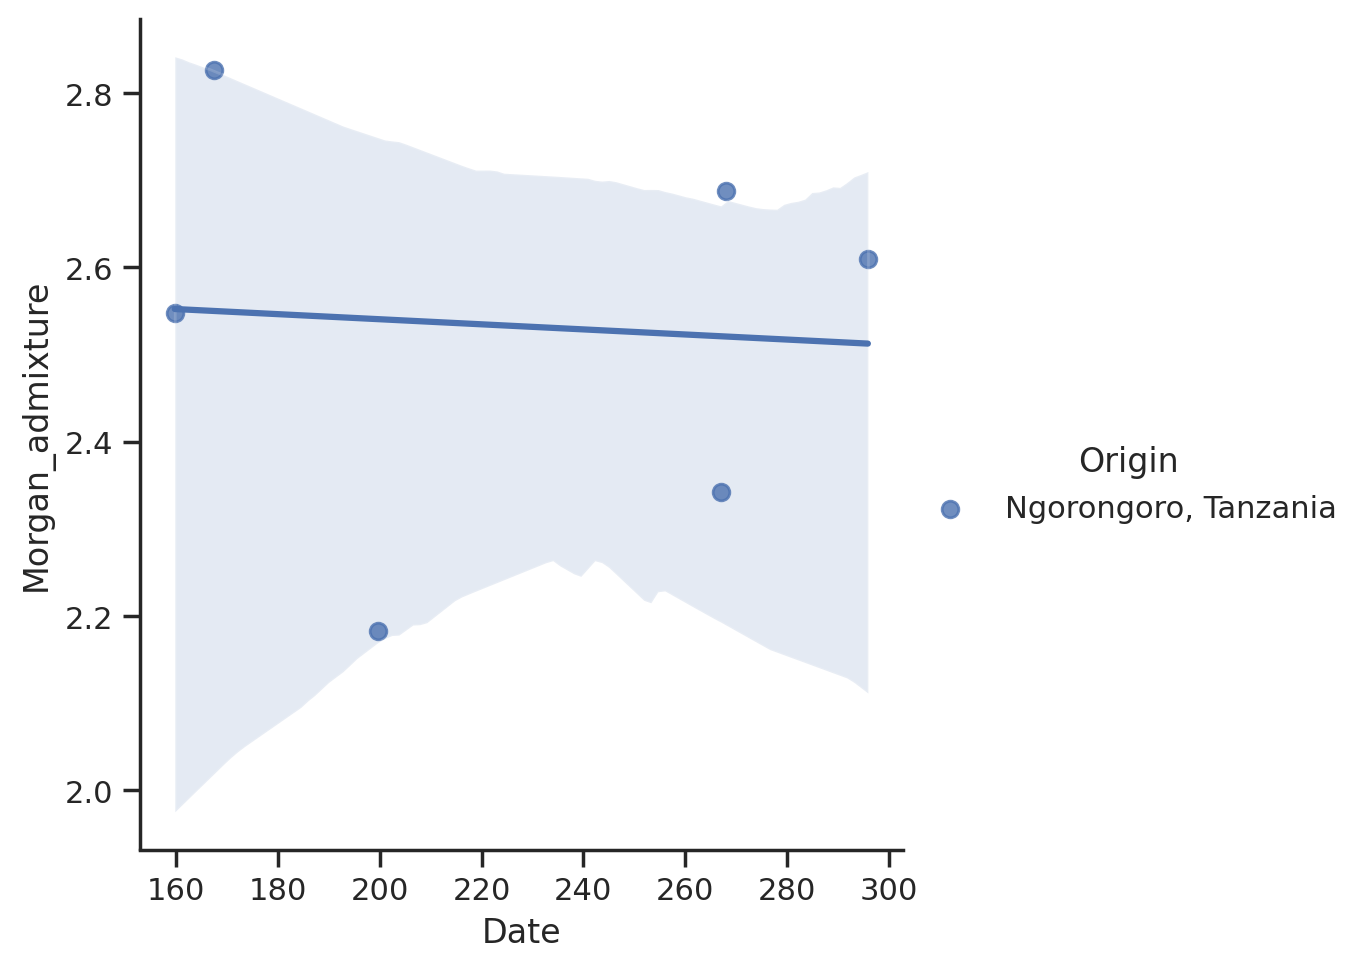

<Figure size 640x480 with 0 Axes>

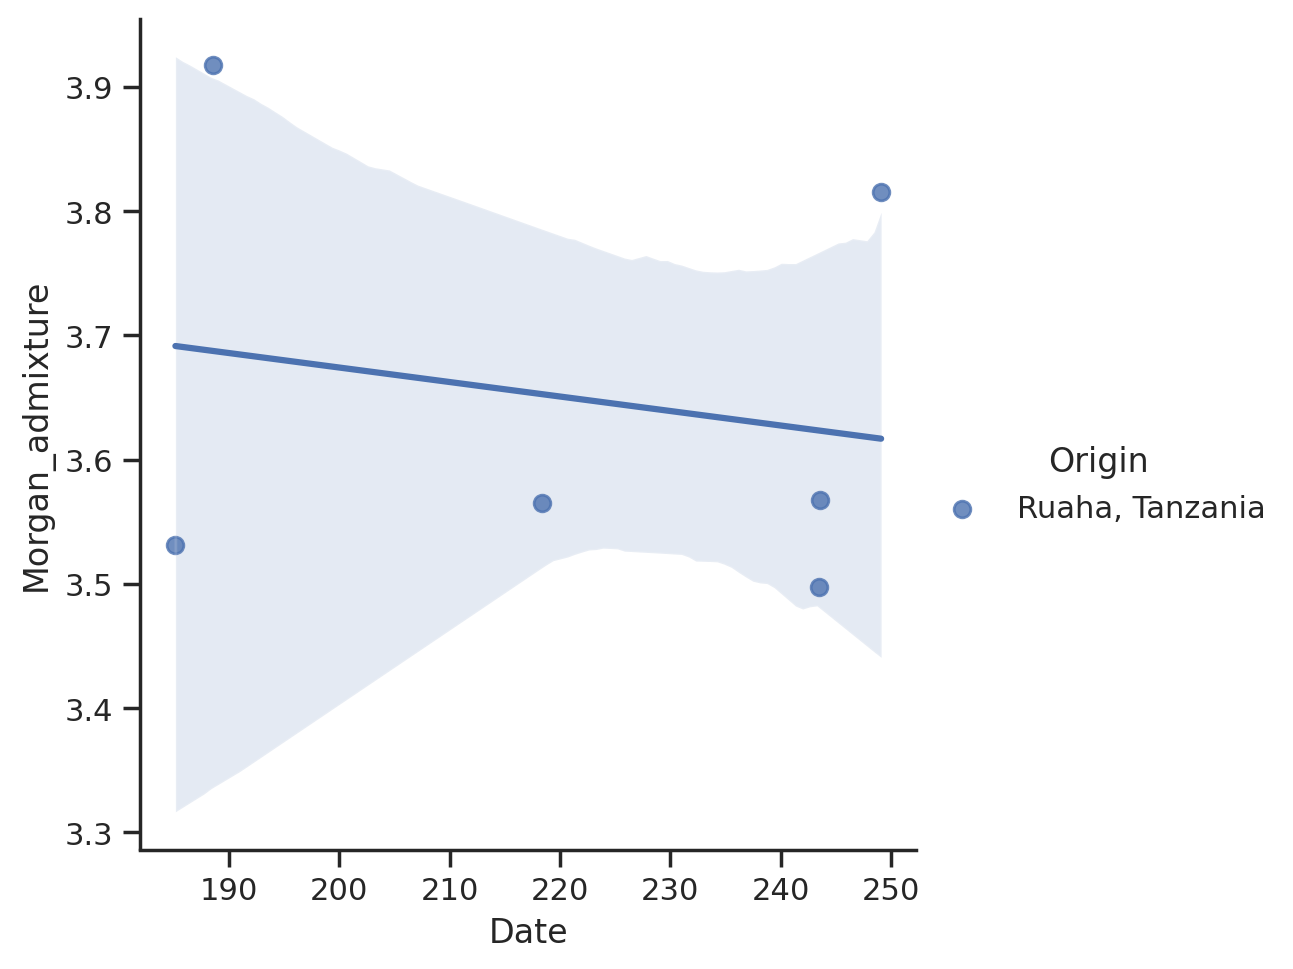

<Figure size 640x480 with 0 Axes>

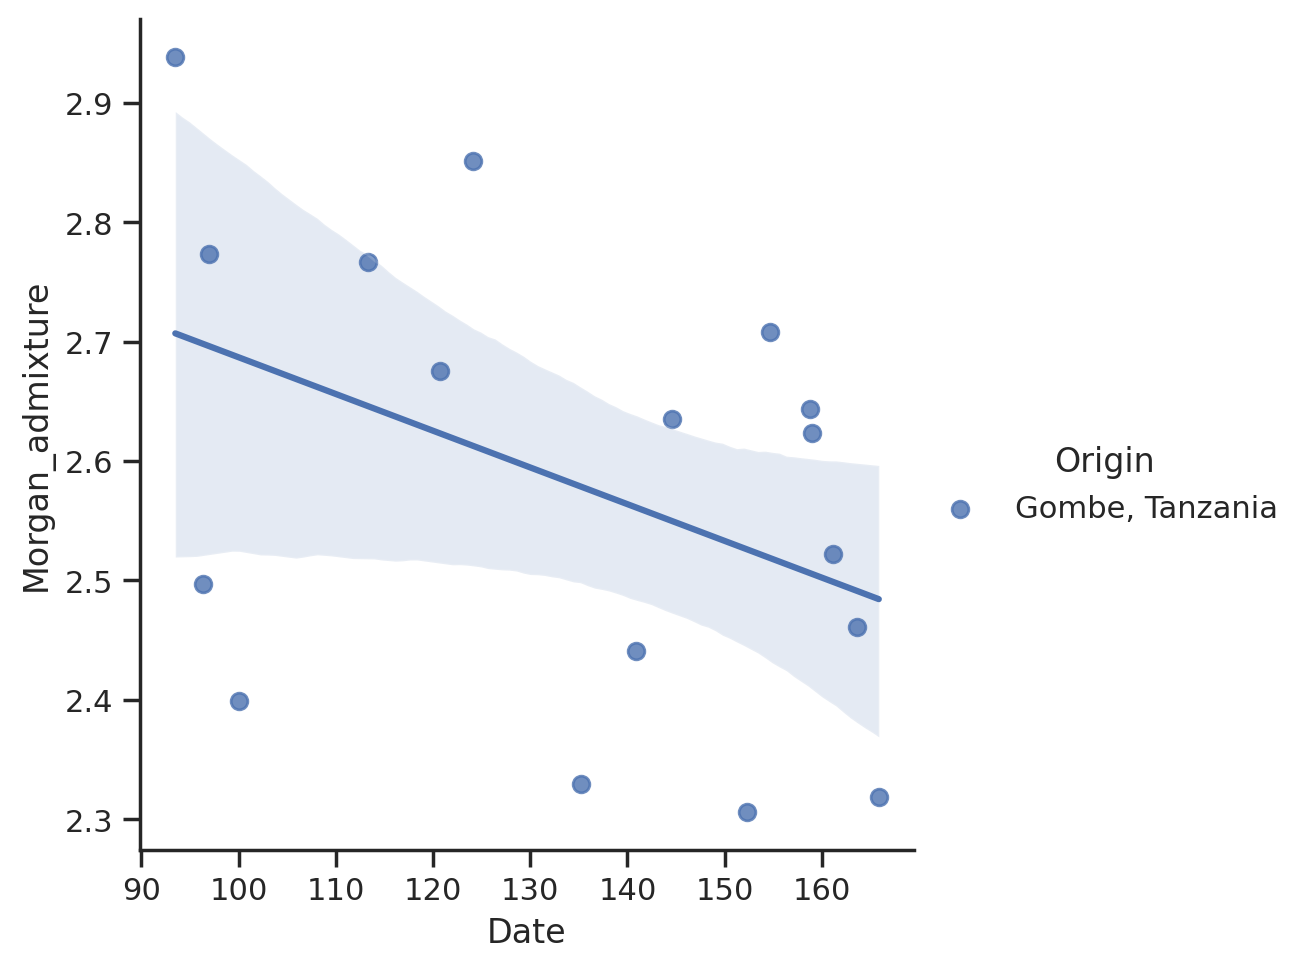

<Figure size 640x480 with 0 Axes>

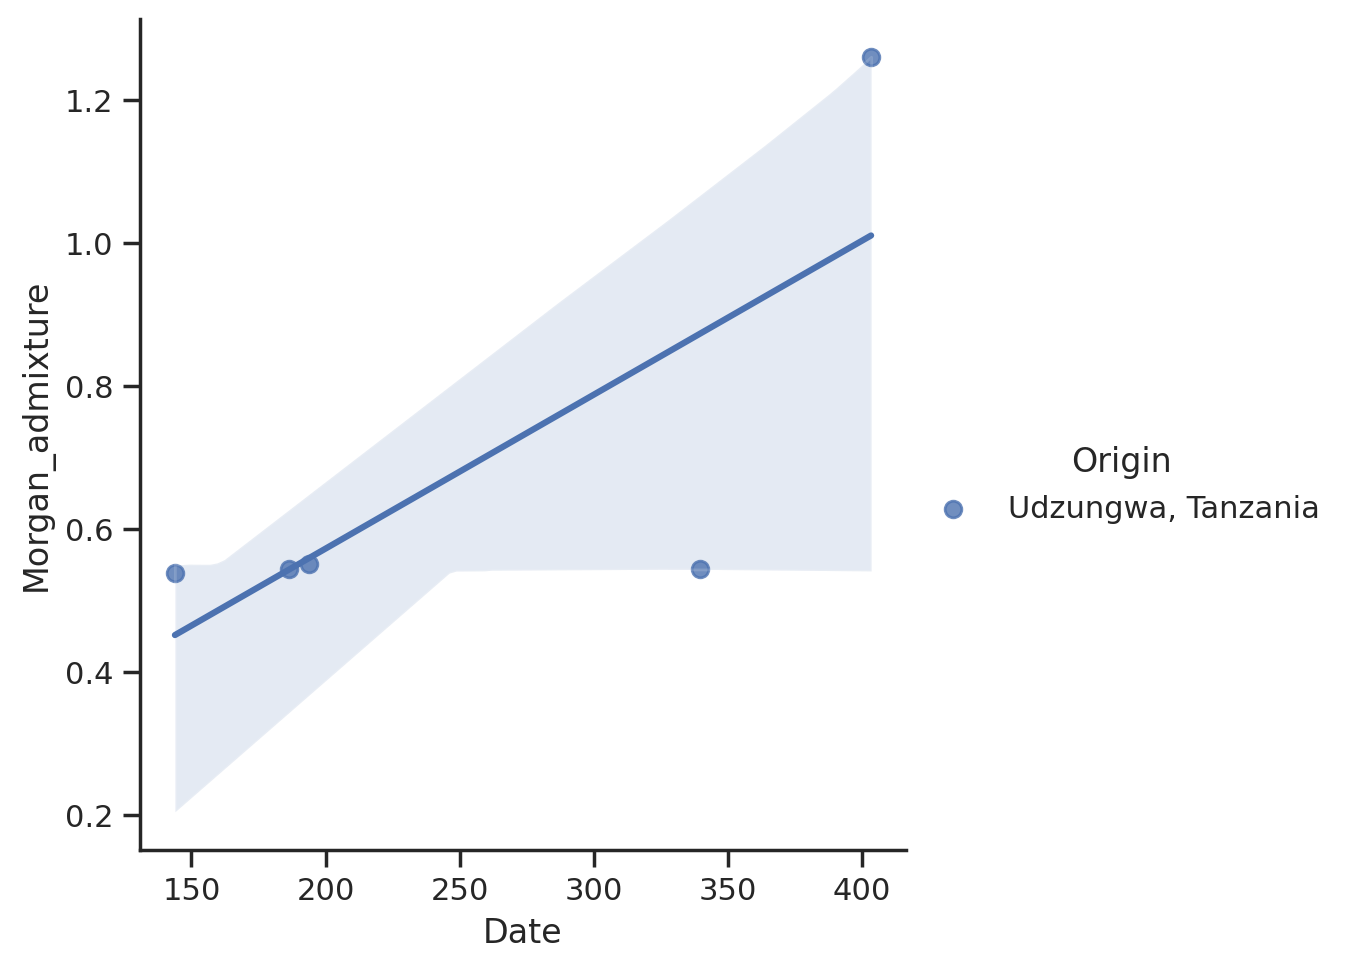

<Figure size 640x480 with 0 Axes>

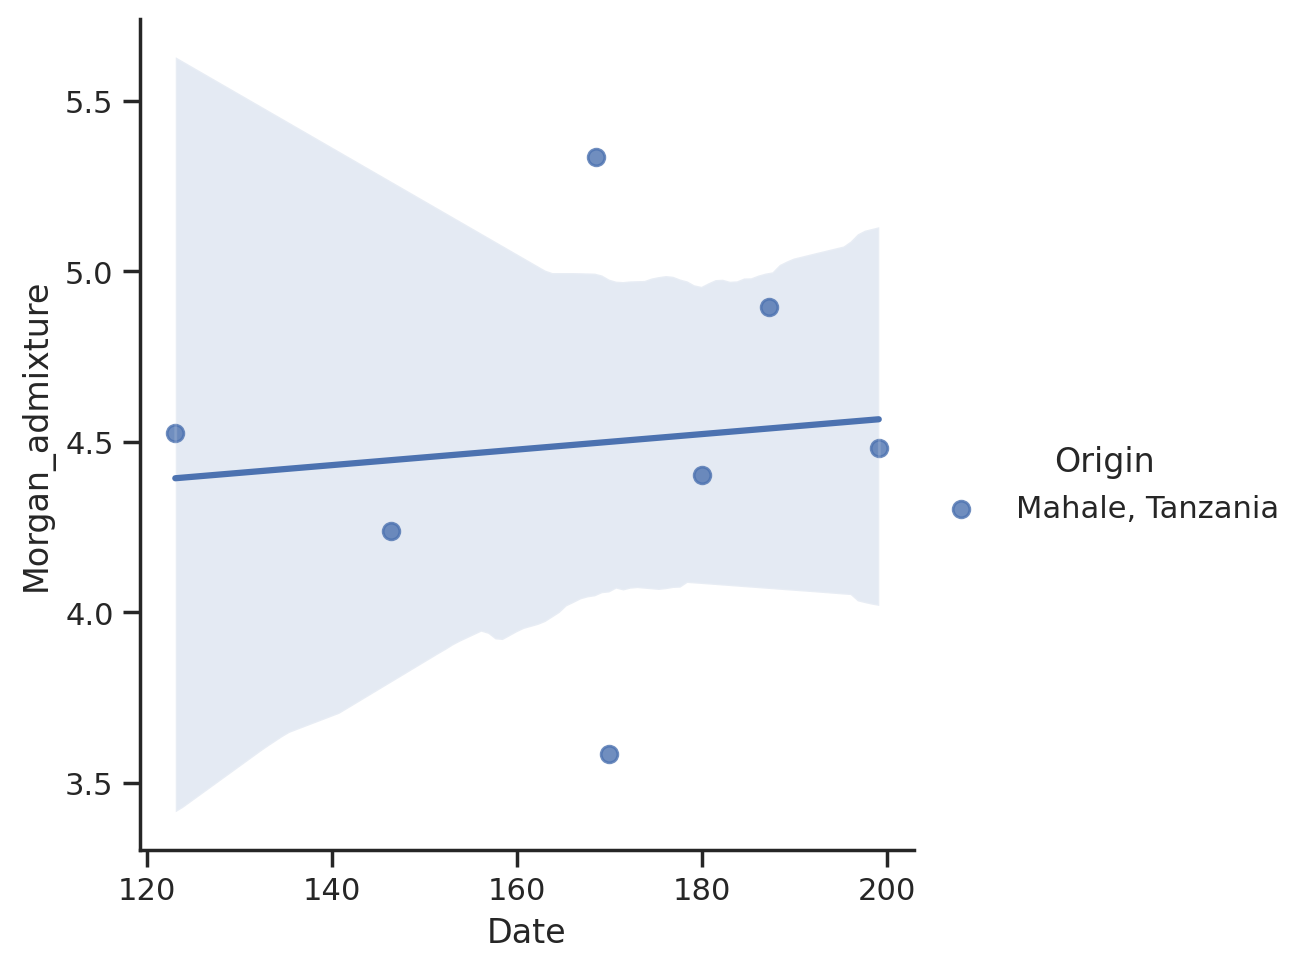

<Figure size 640x480 with 0 Axes>

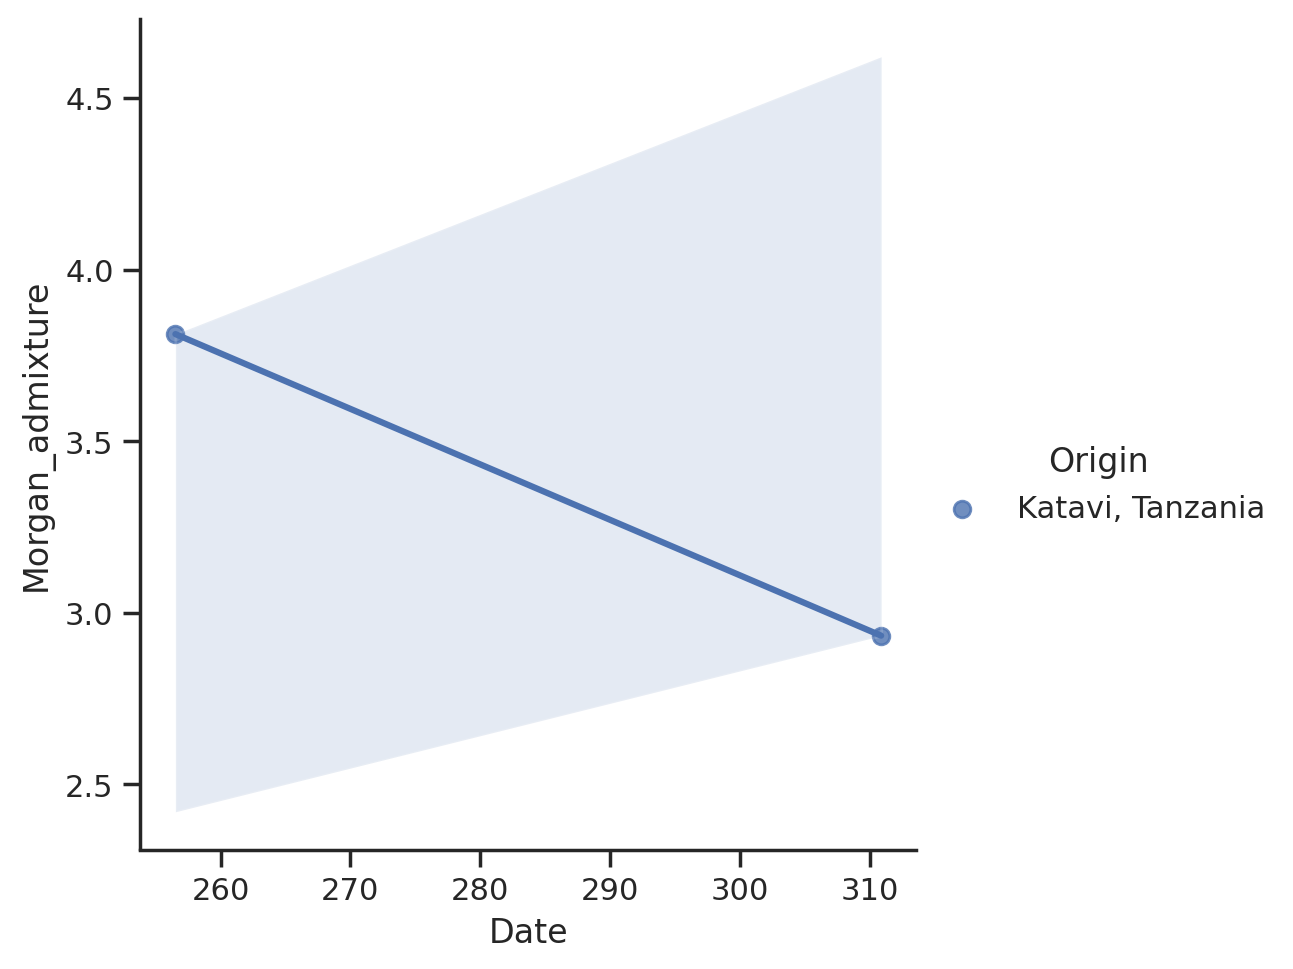

<Figure size 640x480 with 0 Axes>

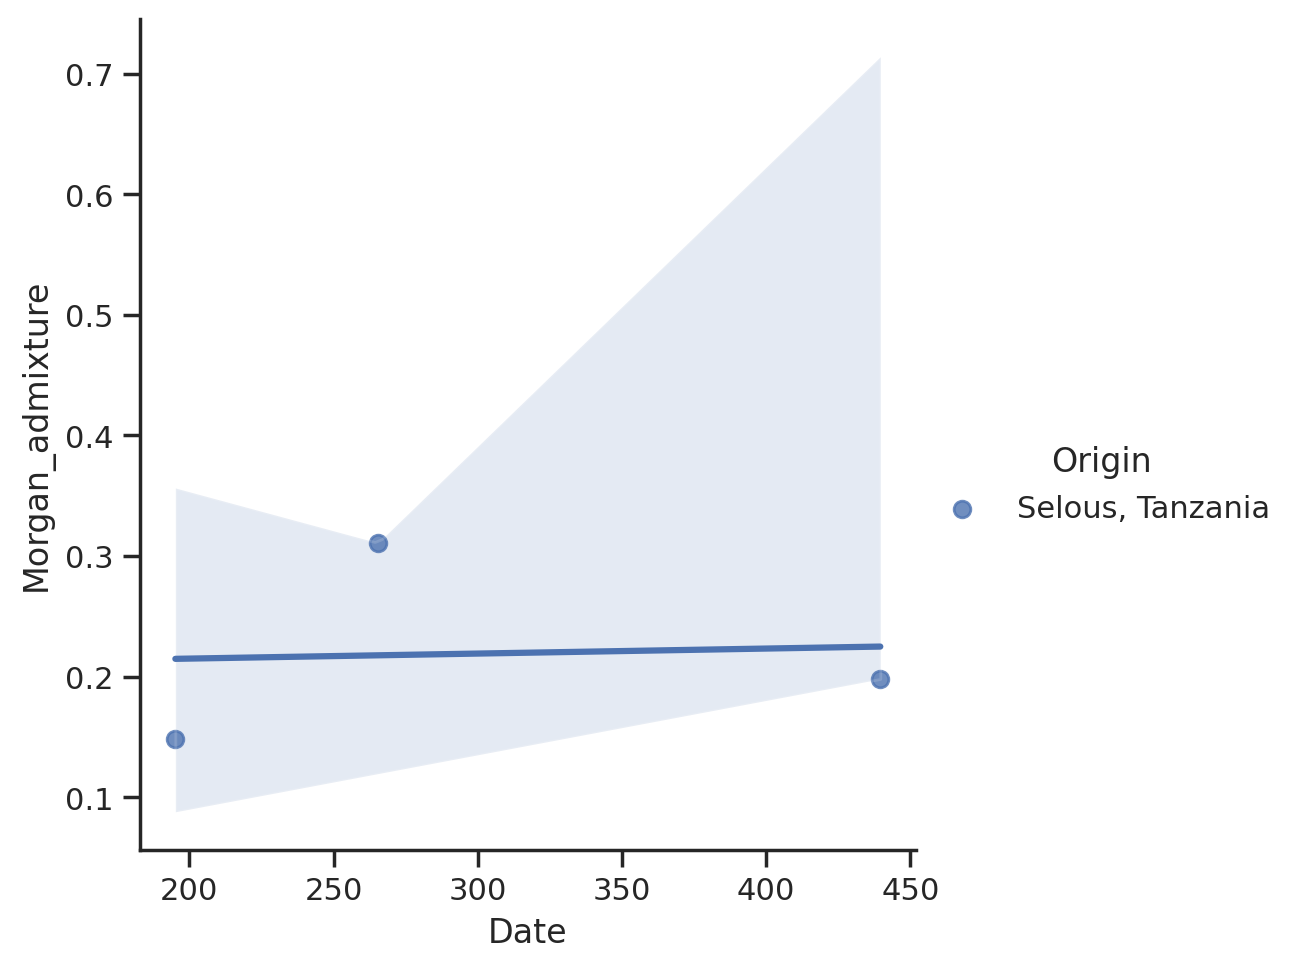

<Figure size 640x480 with 0 Axes>

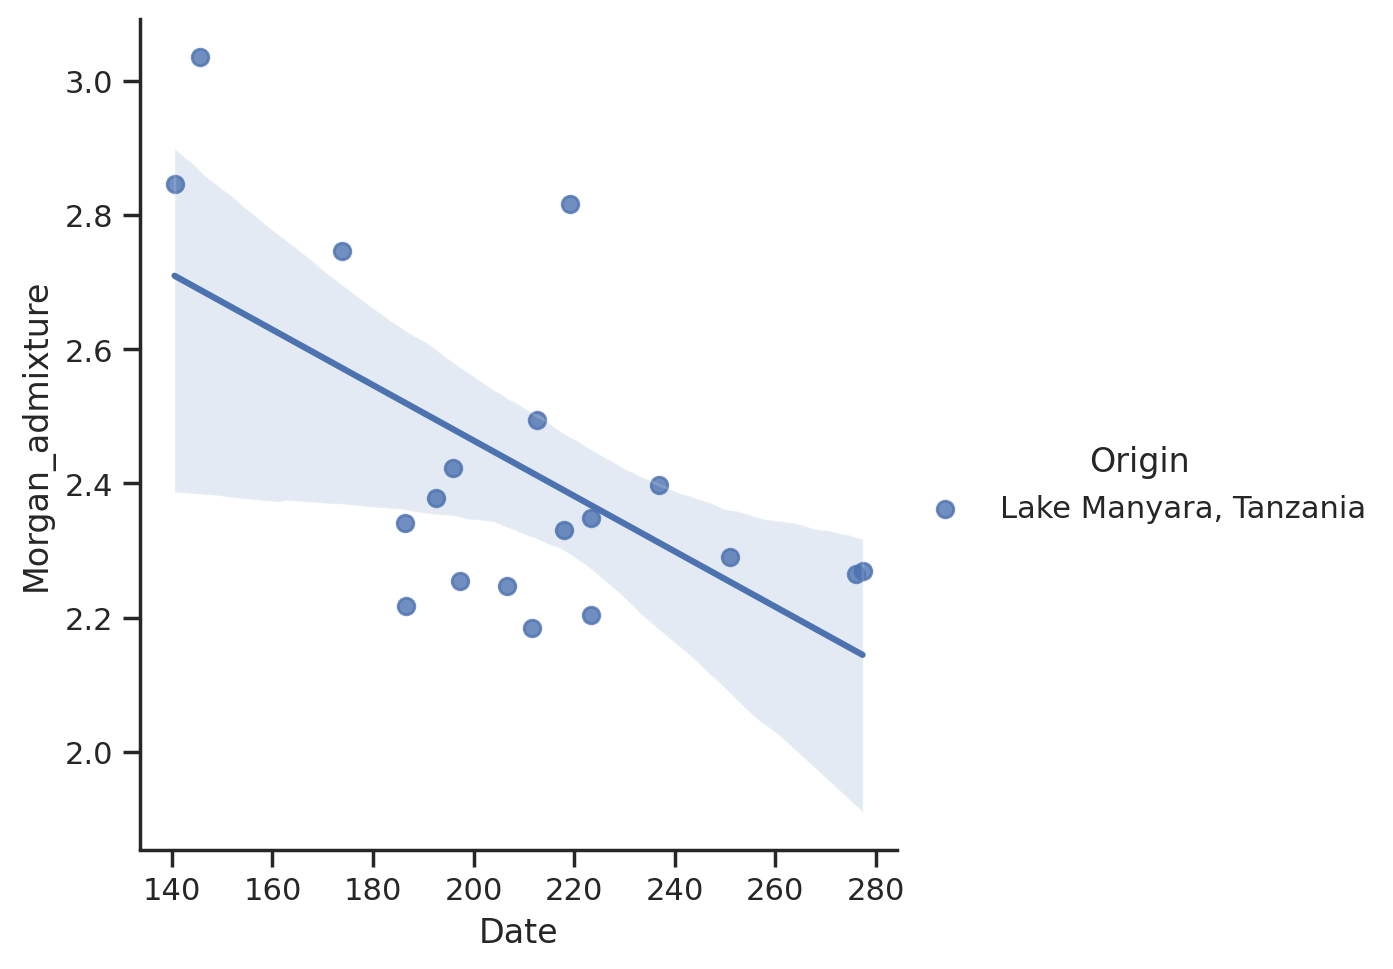

<Figure size 640x480 with 0 Axes>

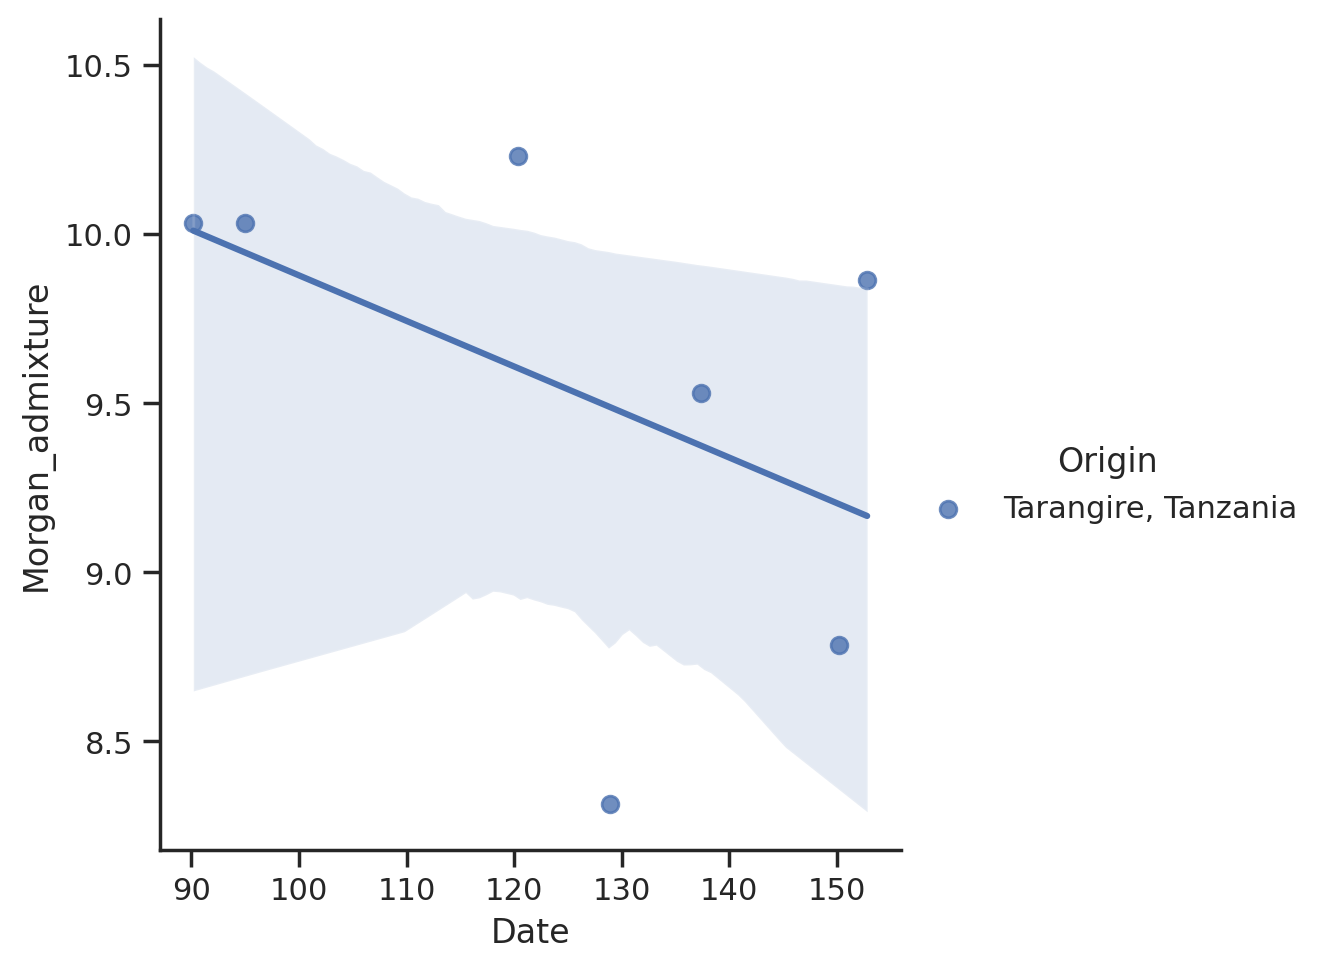

<Figure size 640x480 with 0 Axes>

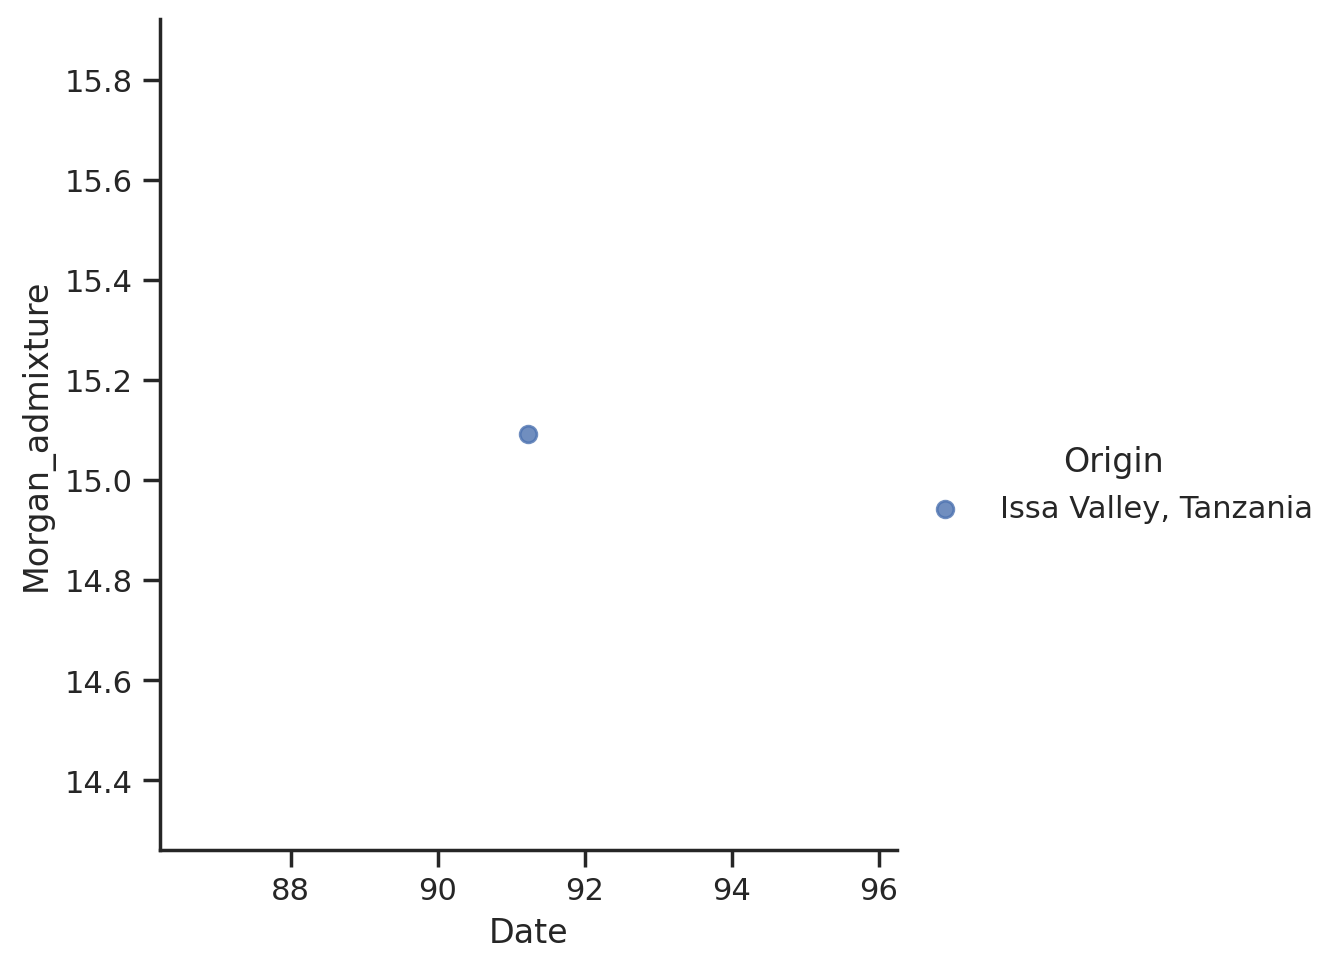

<Figure size 640x480 with 0 Axes>

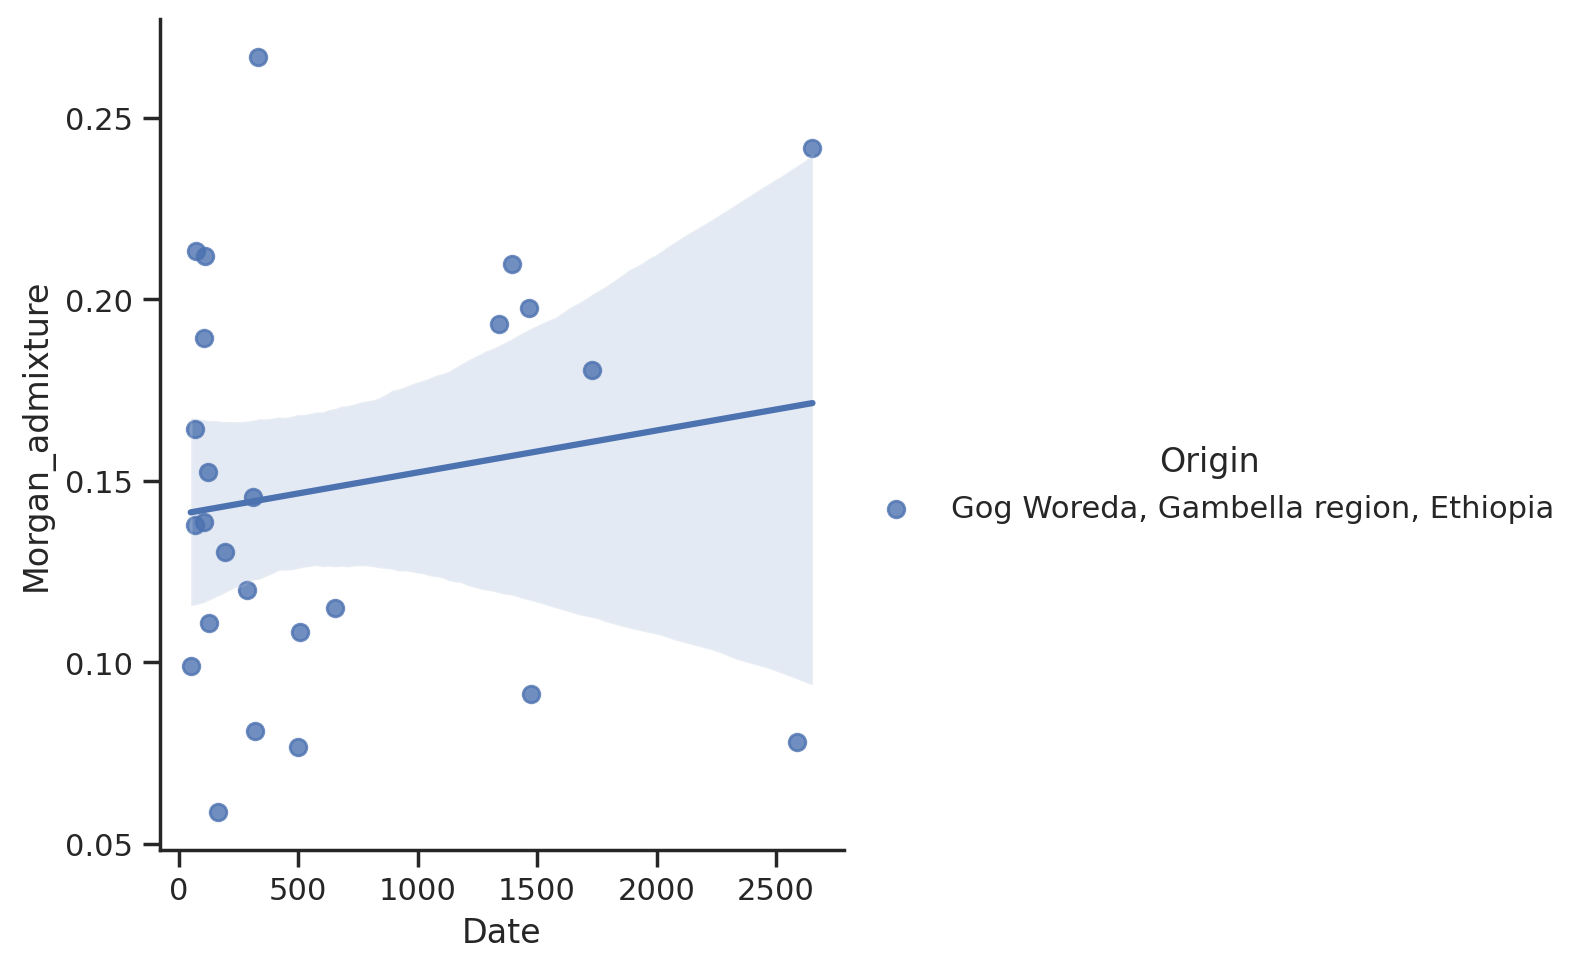

<Figure size 640x480 with 0 Axes>

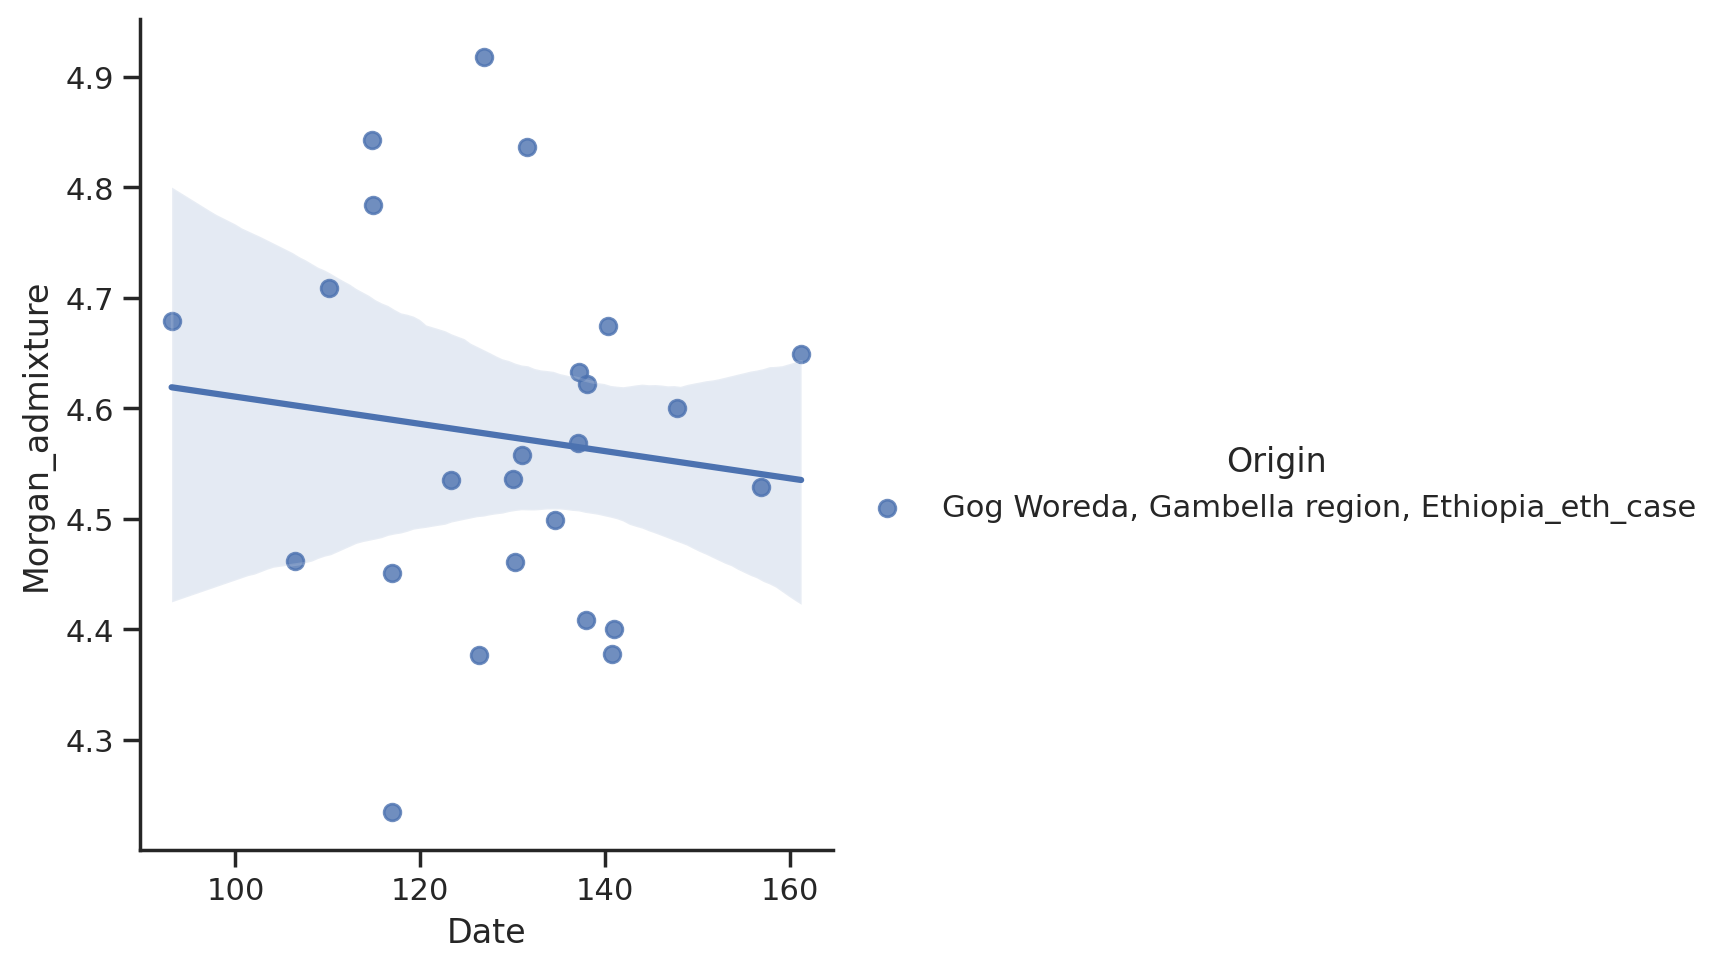

<Figure size 640x480 with 0 Axes>

In [20]:
for x in date_df.Origin.unique():
    sns.lmplot(data=date_df.loc[date_df.Origin == x], x="Date", y="Morgan_admixture", hue="Origin")
    plt.figure()

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


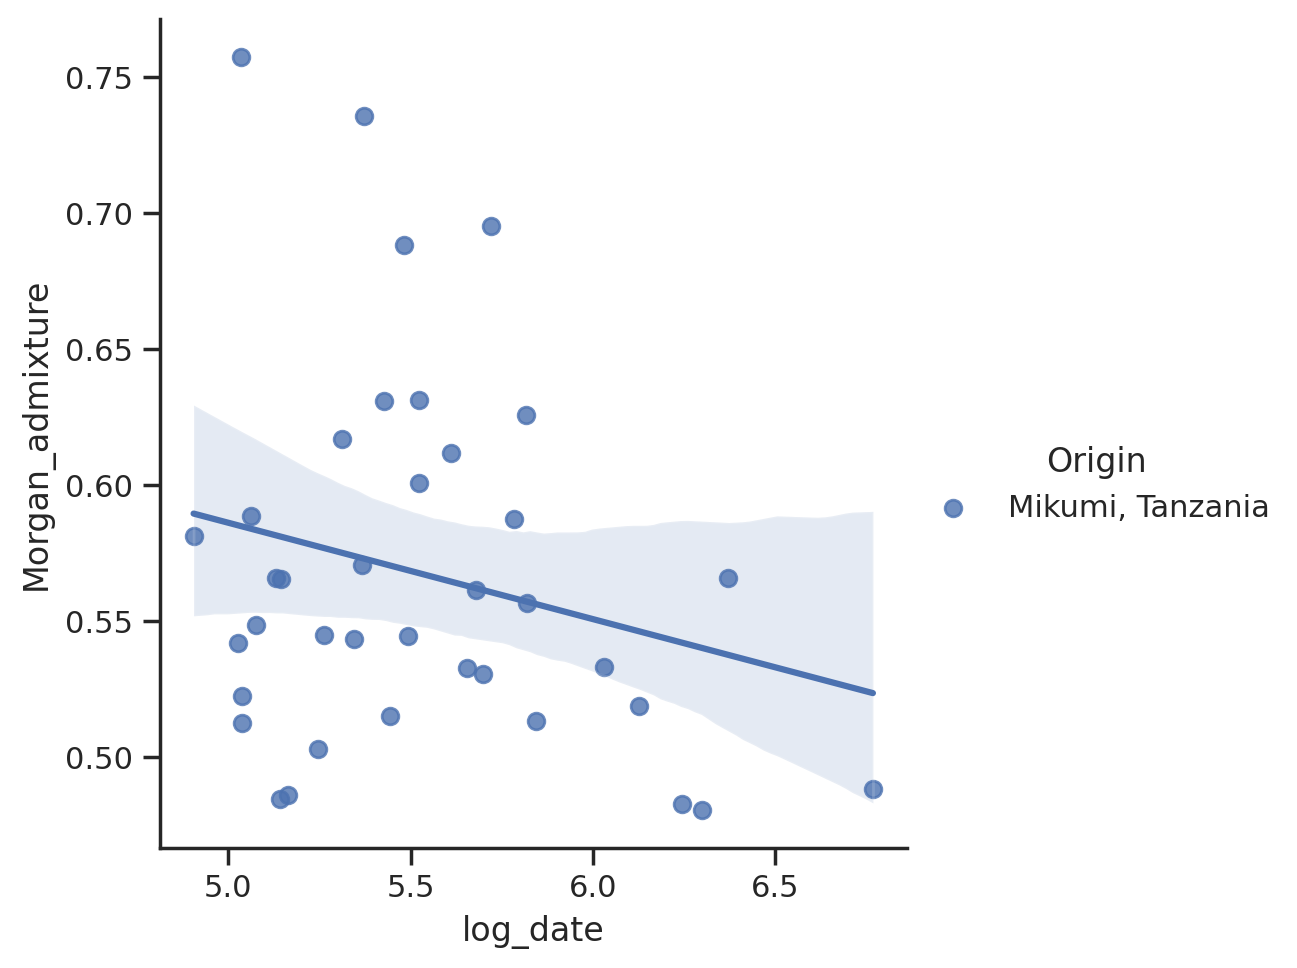

<Figure size 640x480 with 0 Axes>

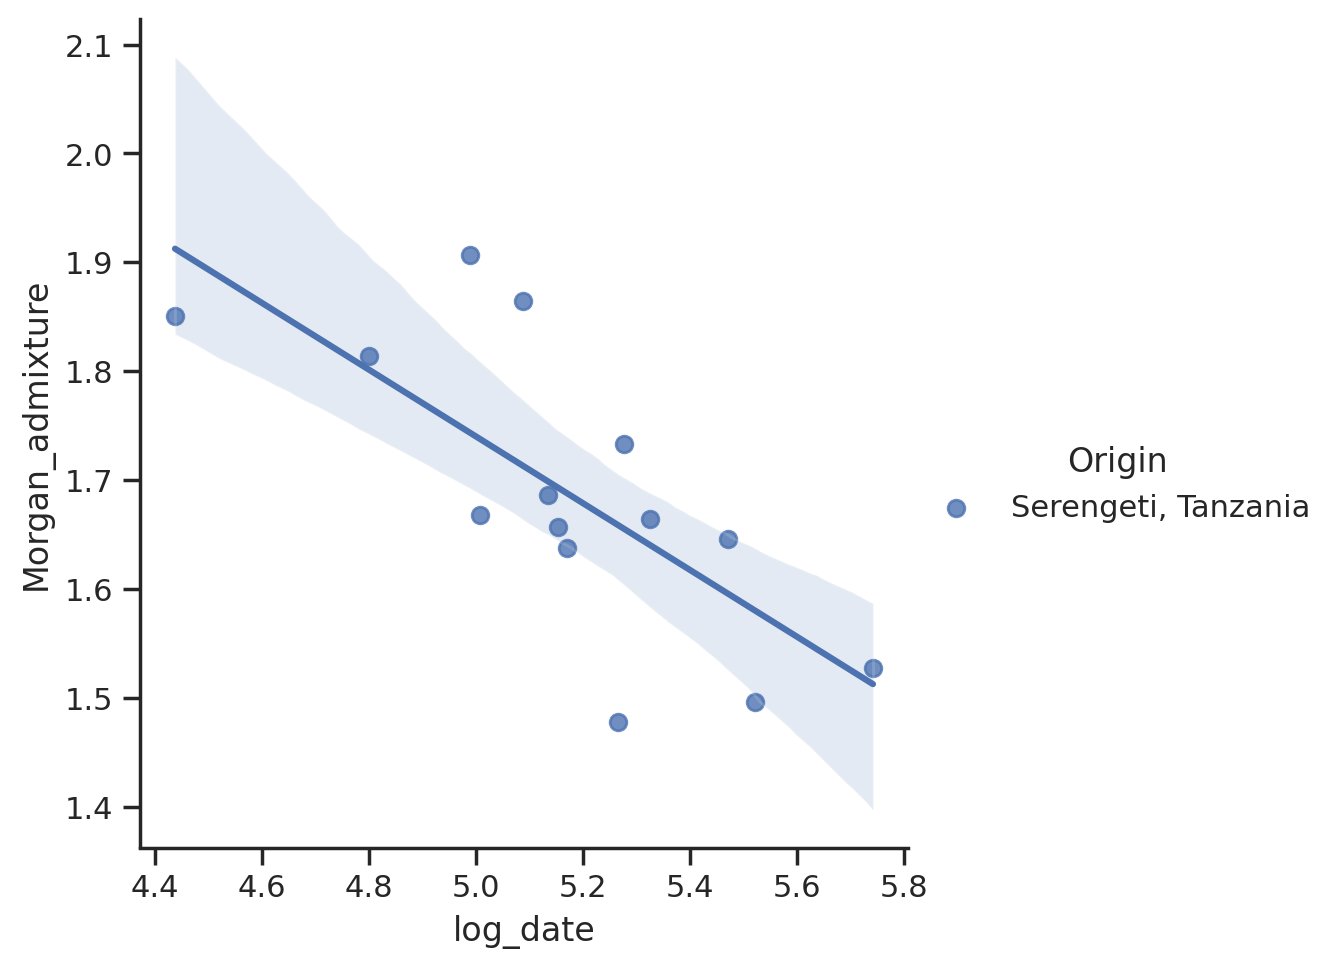

<Figure size 640x480 with 0 Axes>

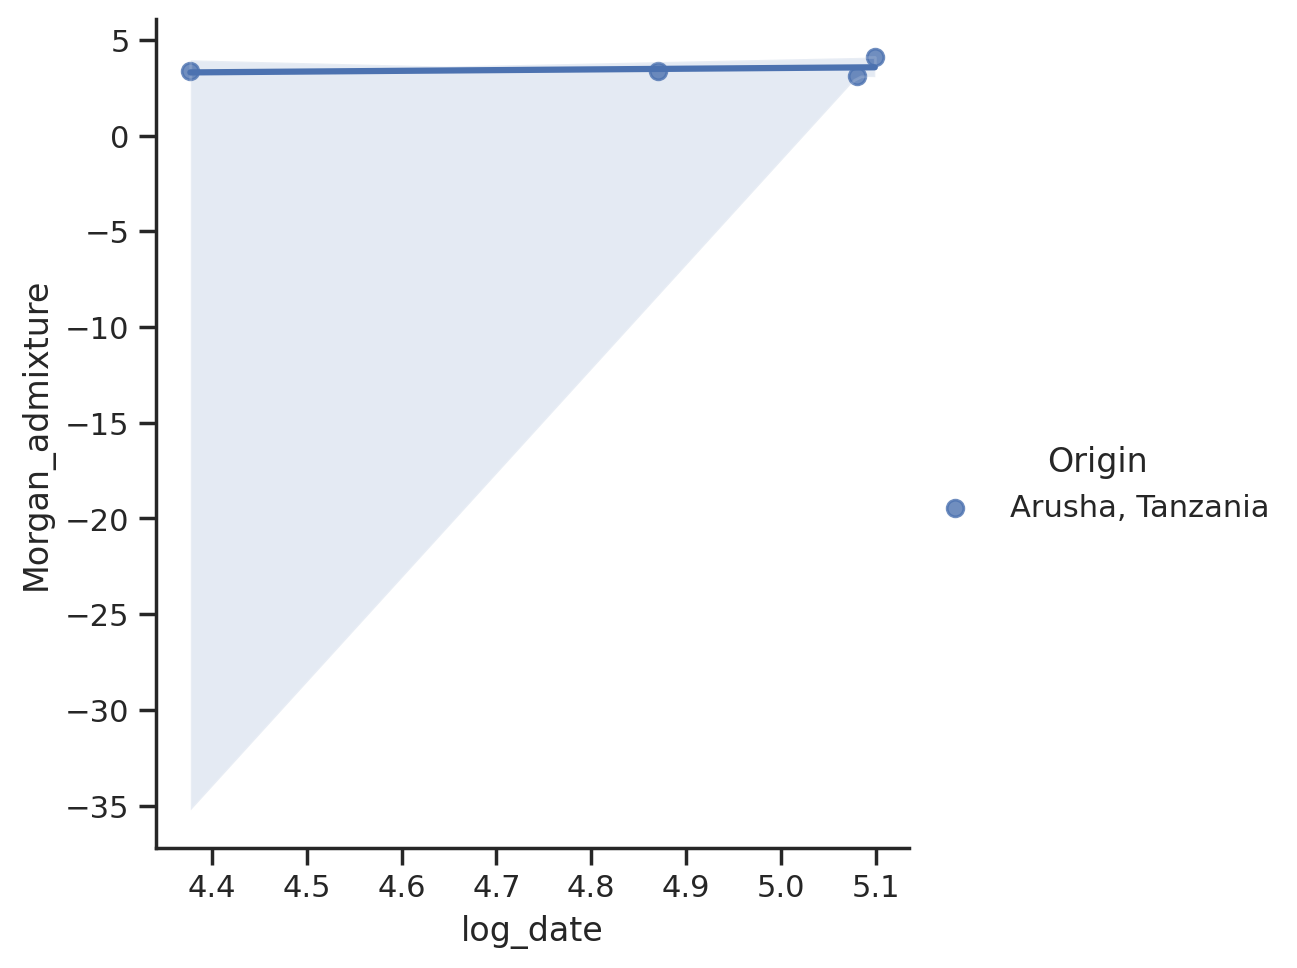

<Figure size 640x480 with 0 Axes>

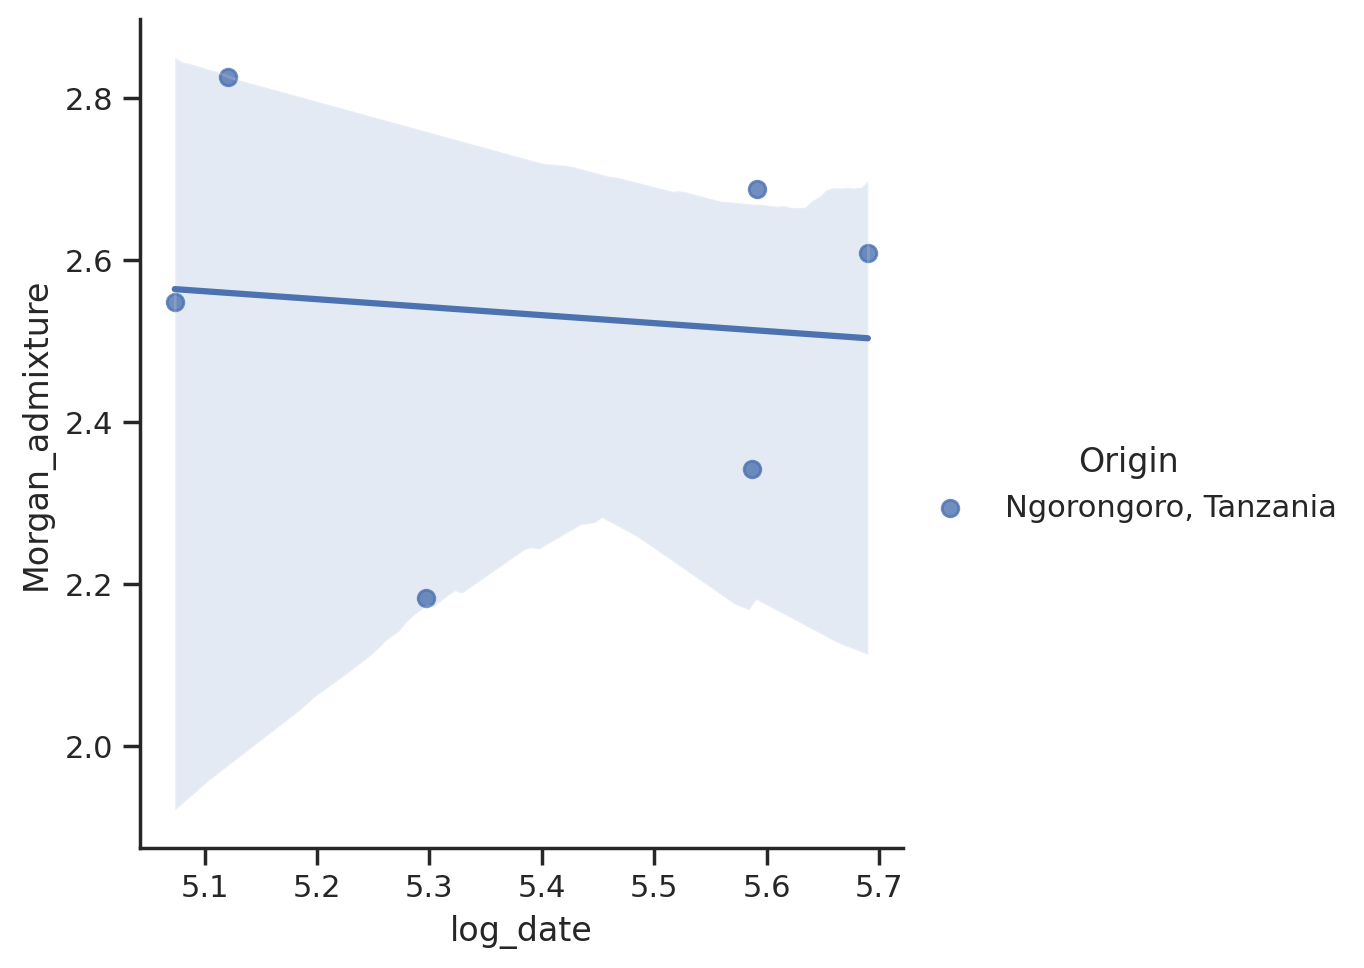

<Figure size 640x480 with 0 Axes>

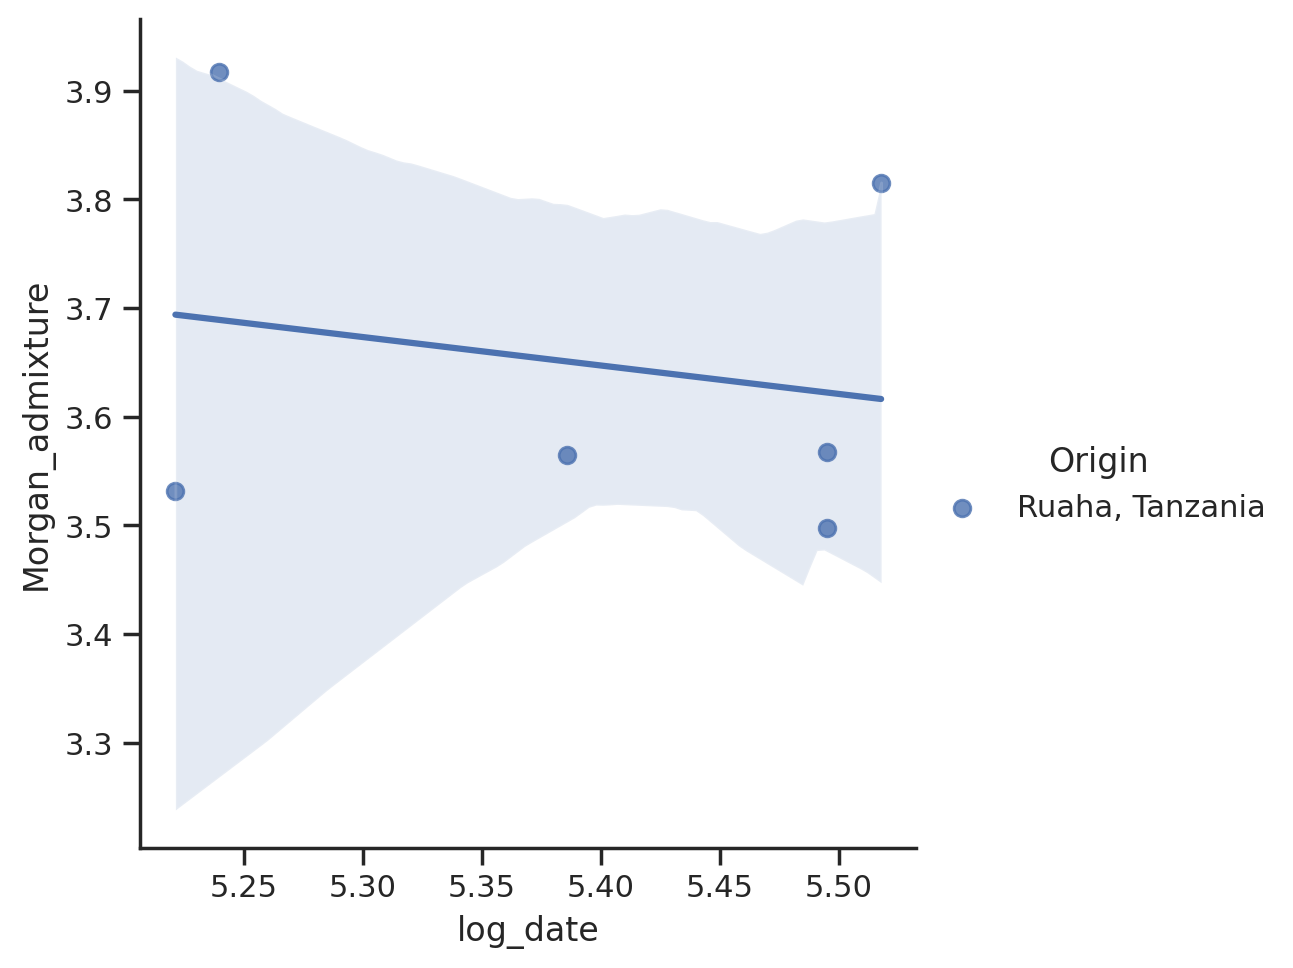

<Figure size 640x480 with 0 Axes>

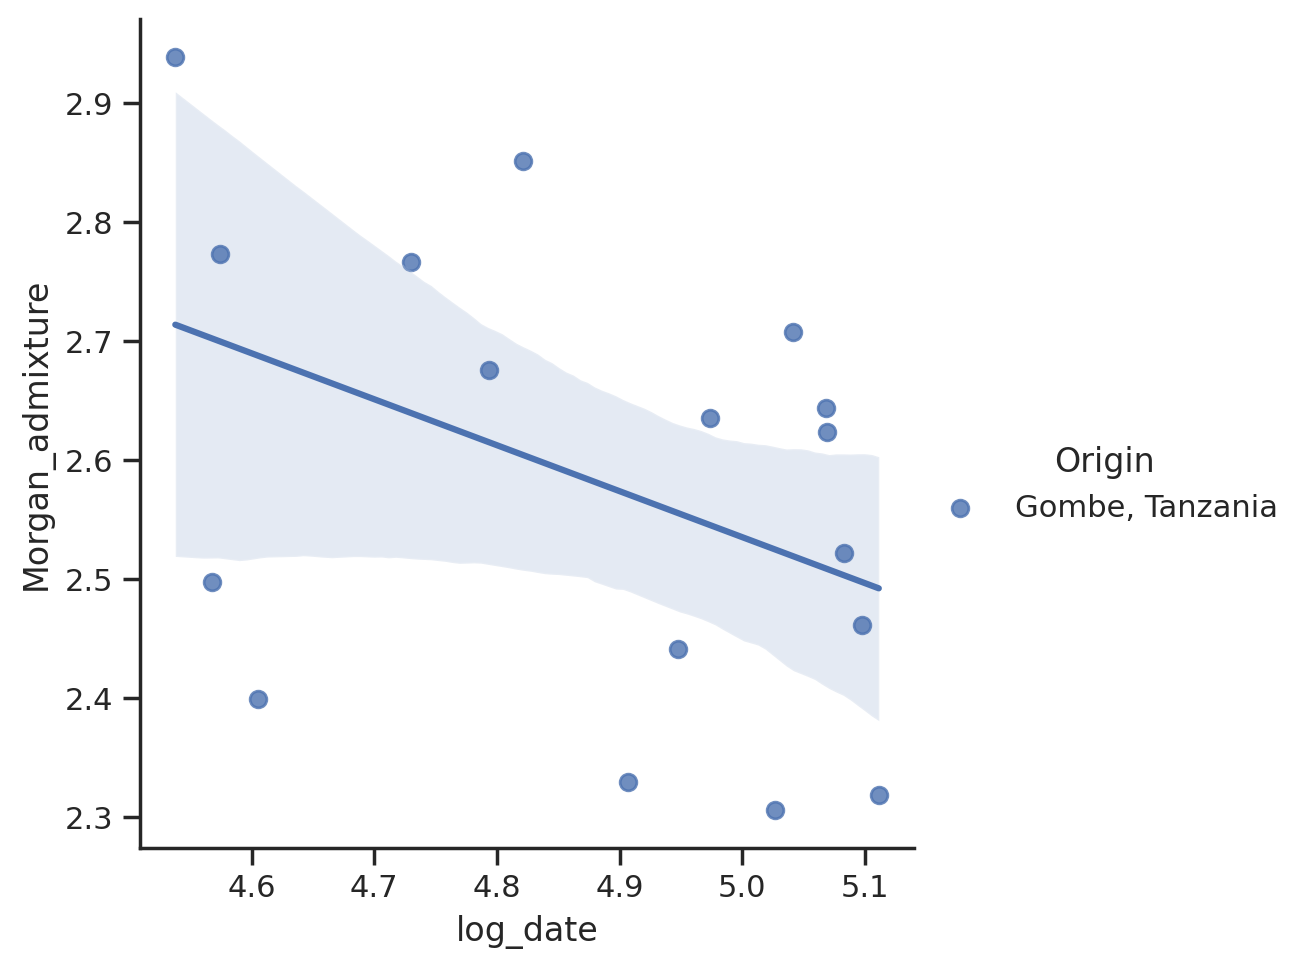

<Figure size 640x480 with 0 Axes>

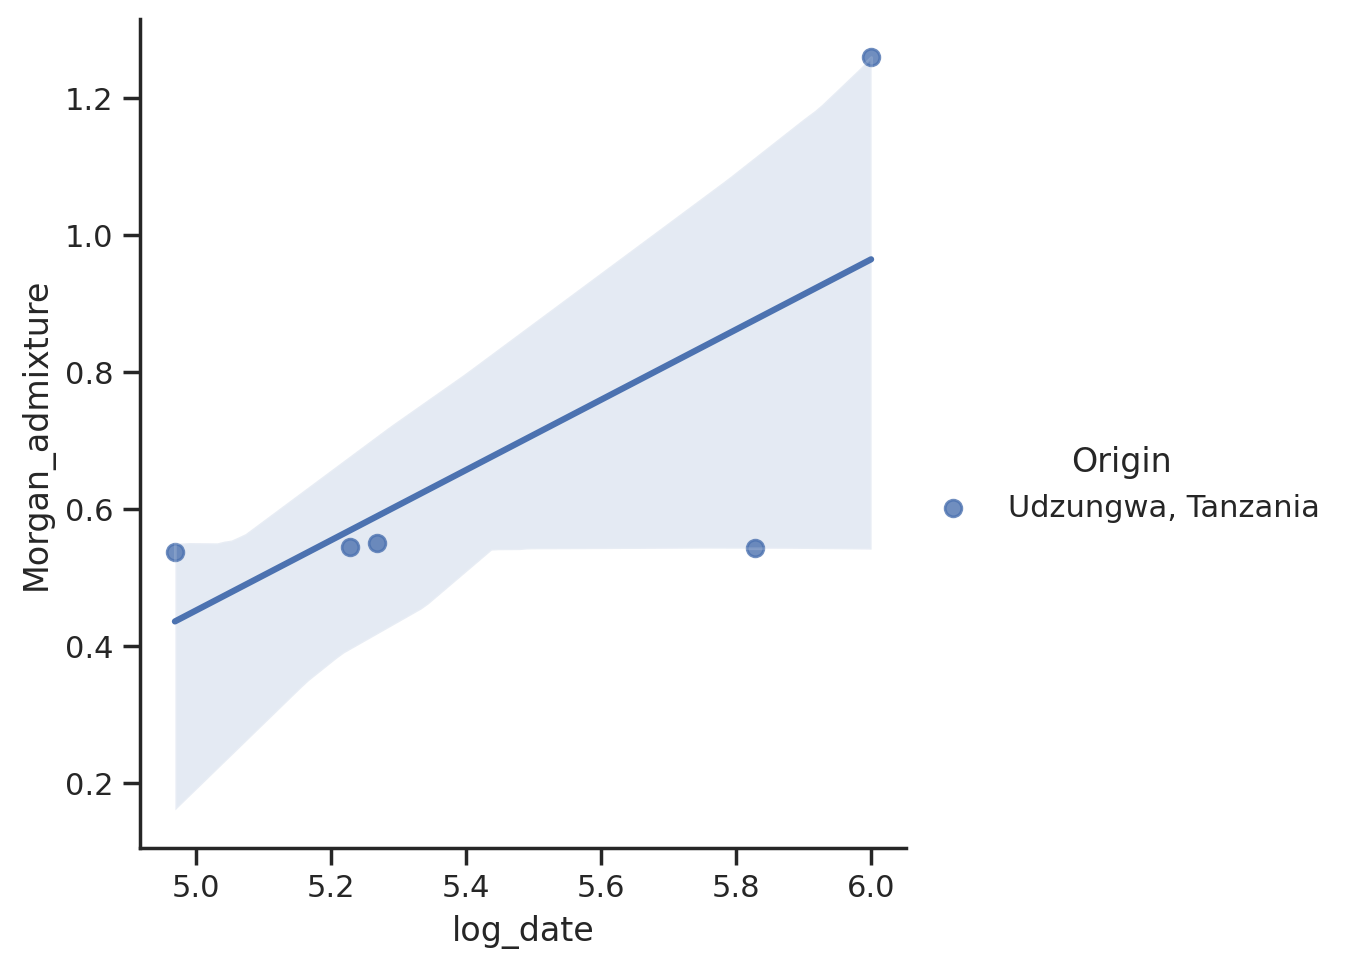

<Figure size 640x480 with 0 Axes>

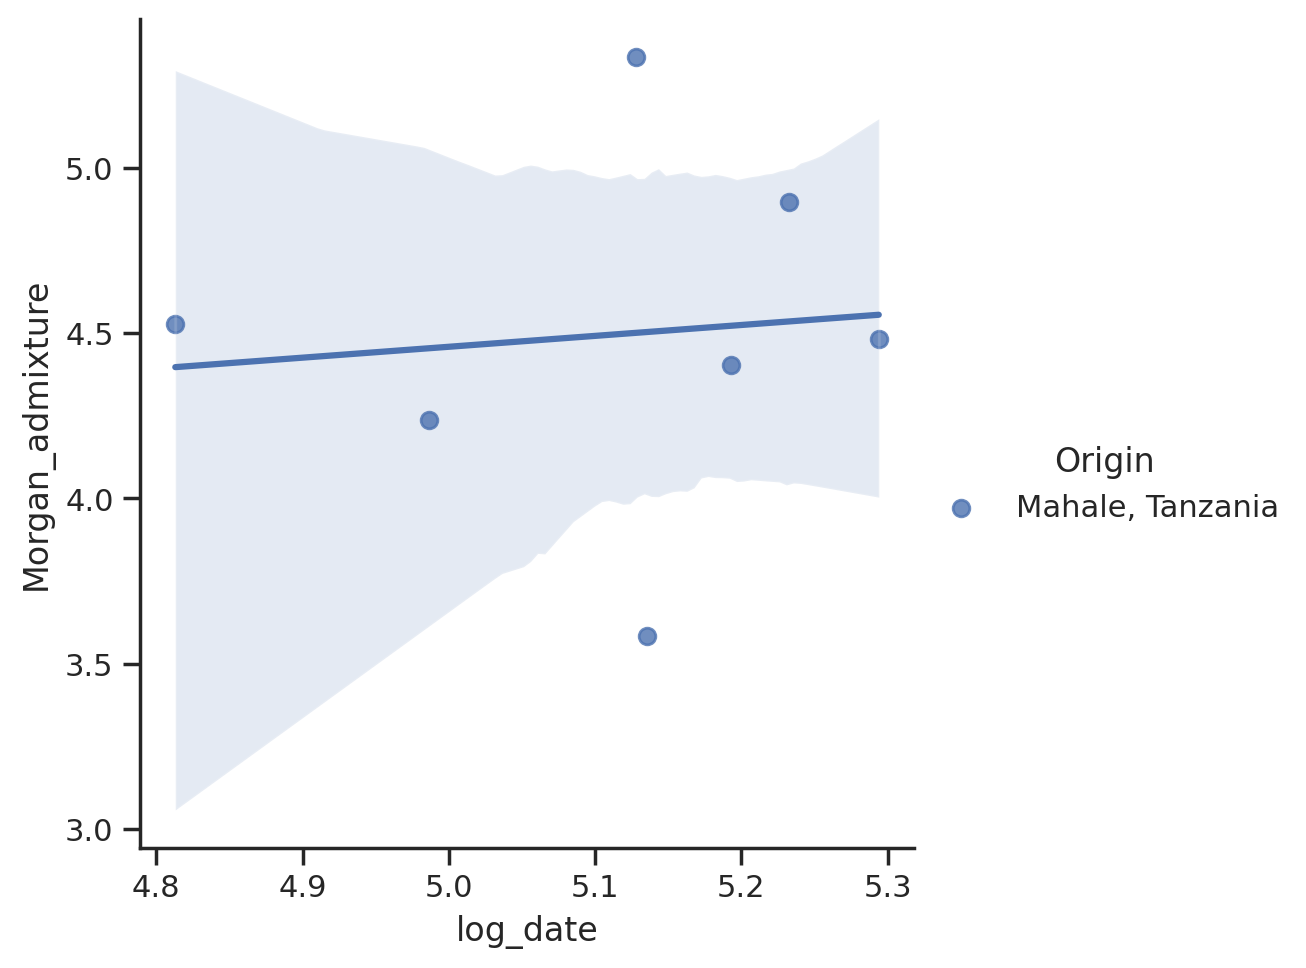

<Figure size 640x480 with 0 Axes>

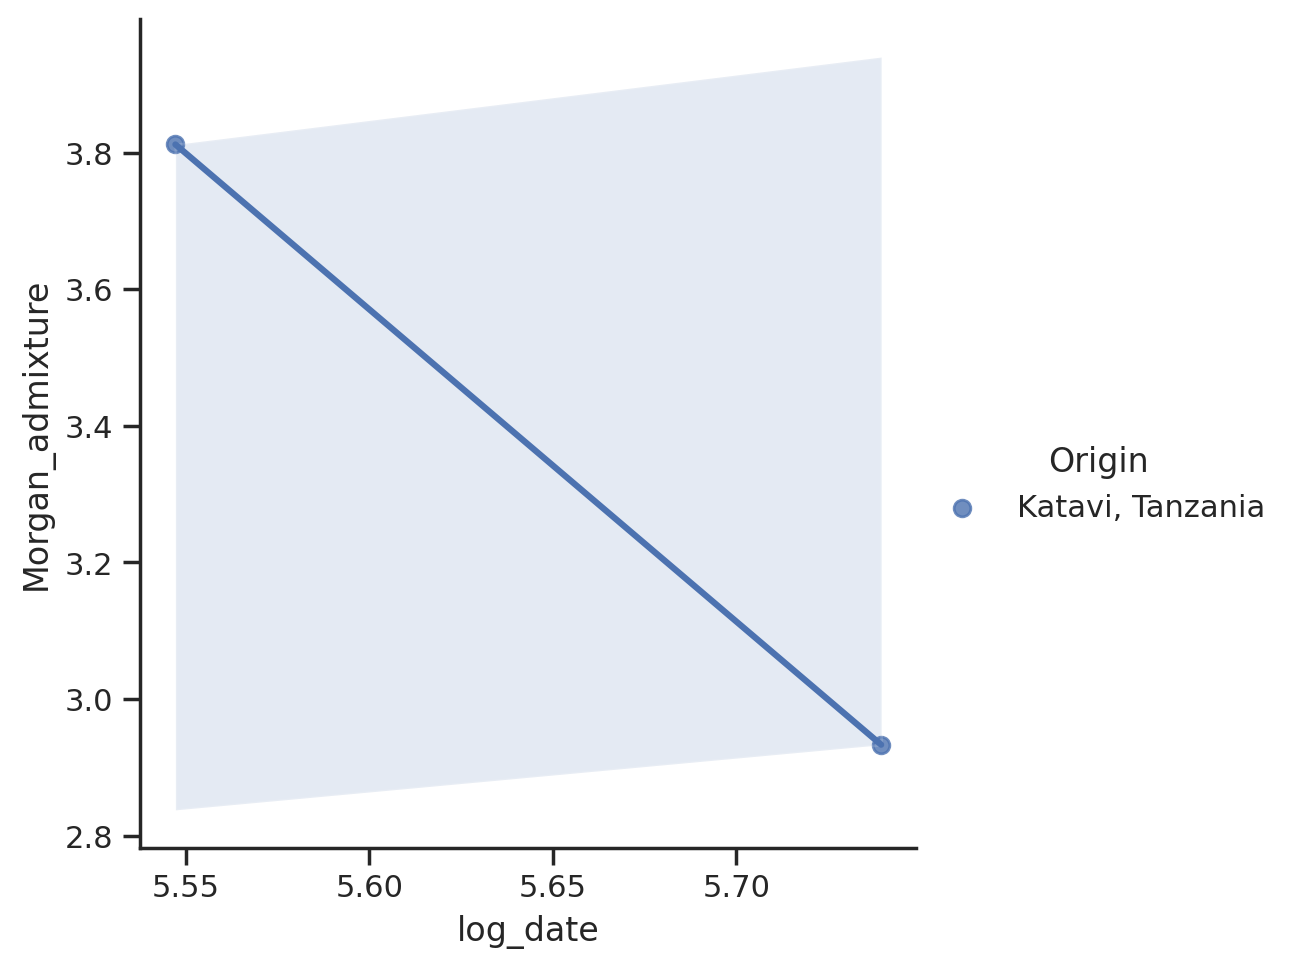

<Figure size 640x480 with 0 Axes>

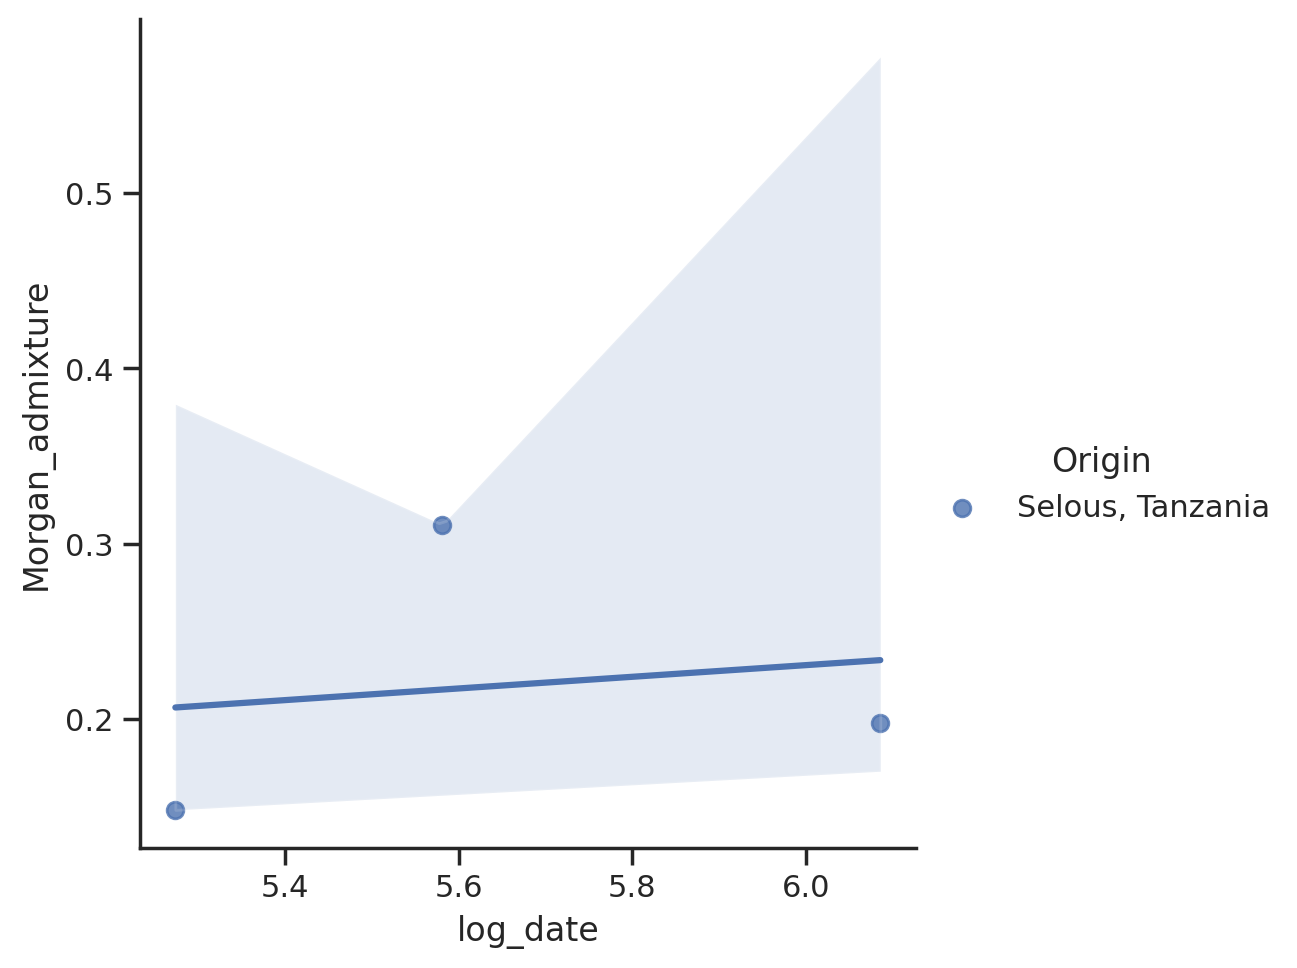

<Figure size 640x480 with 0 Axes>

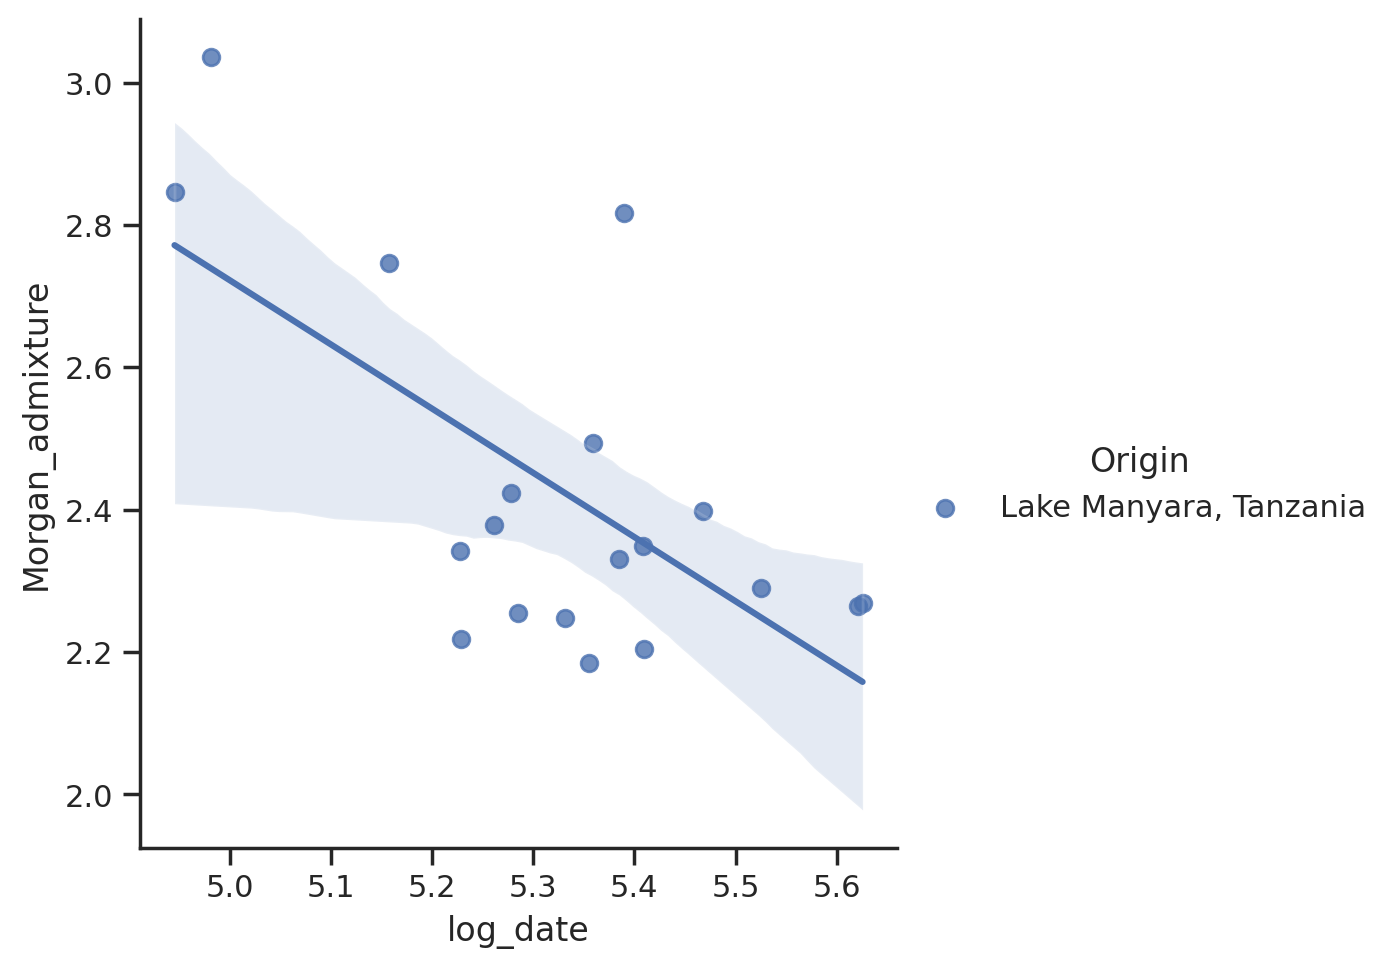

<Figure size 640x480 with 0 Axes>

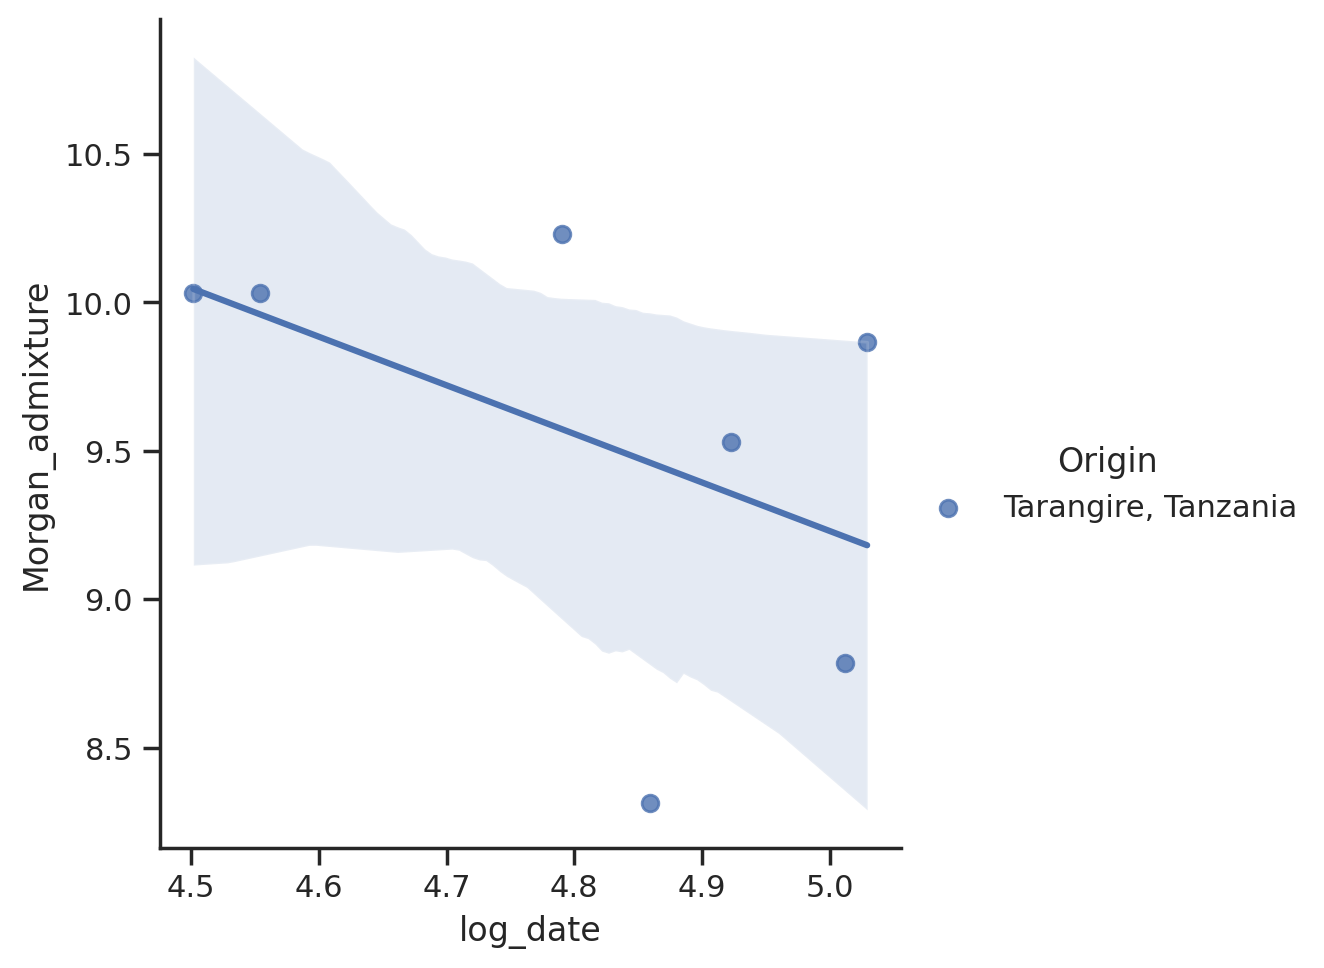

<Figure size 640x480 with 0 Axes>

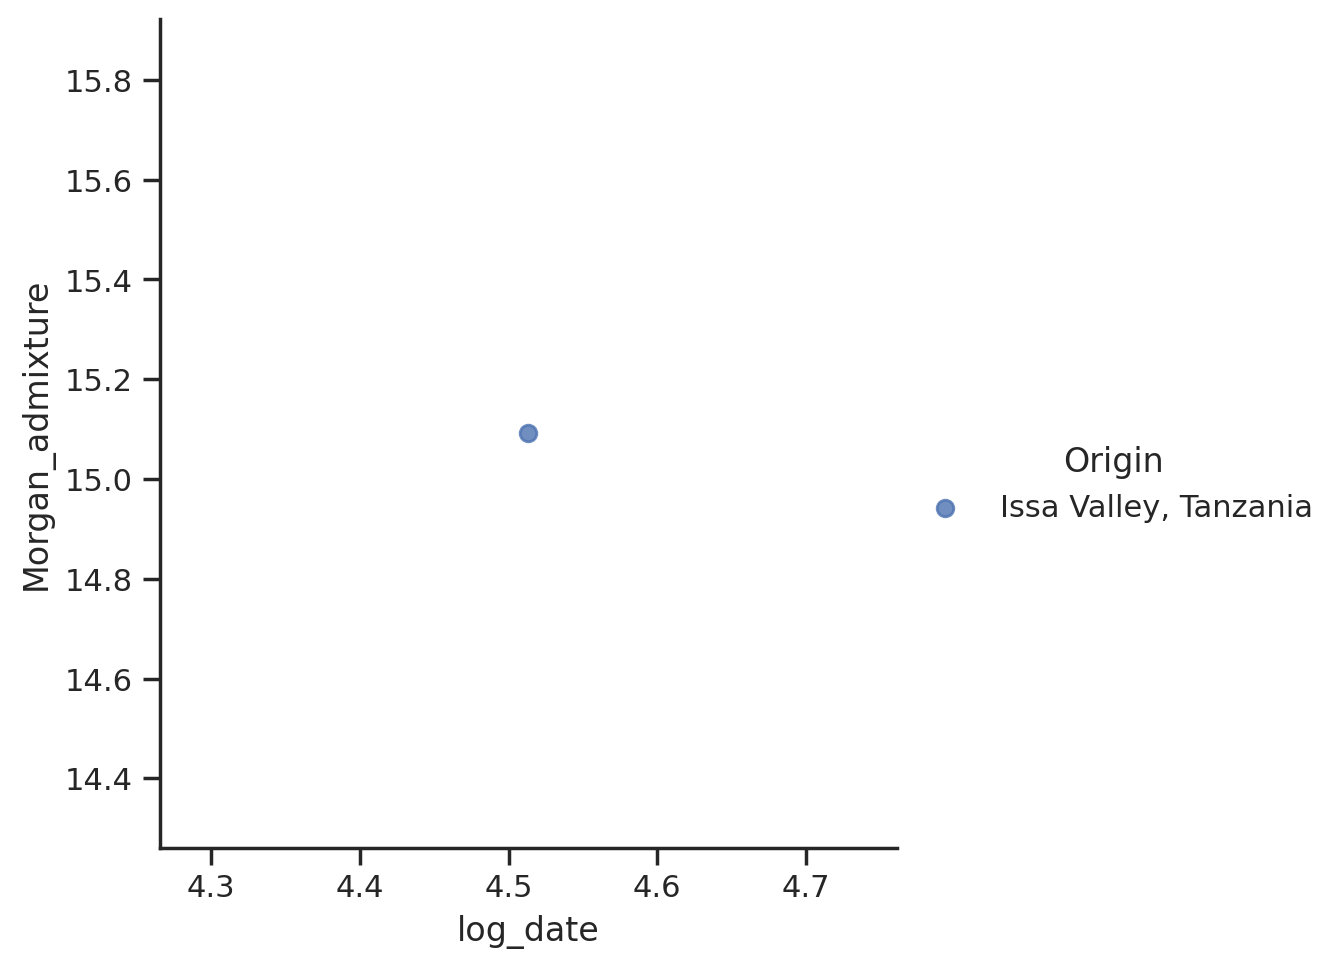

<Figure size 640x480 with 0 Axes>

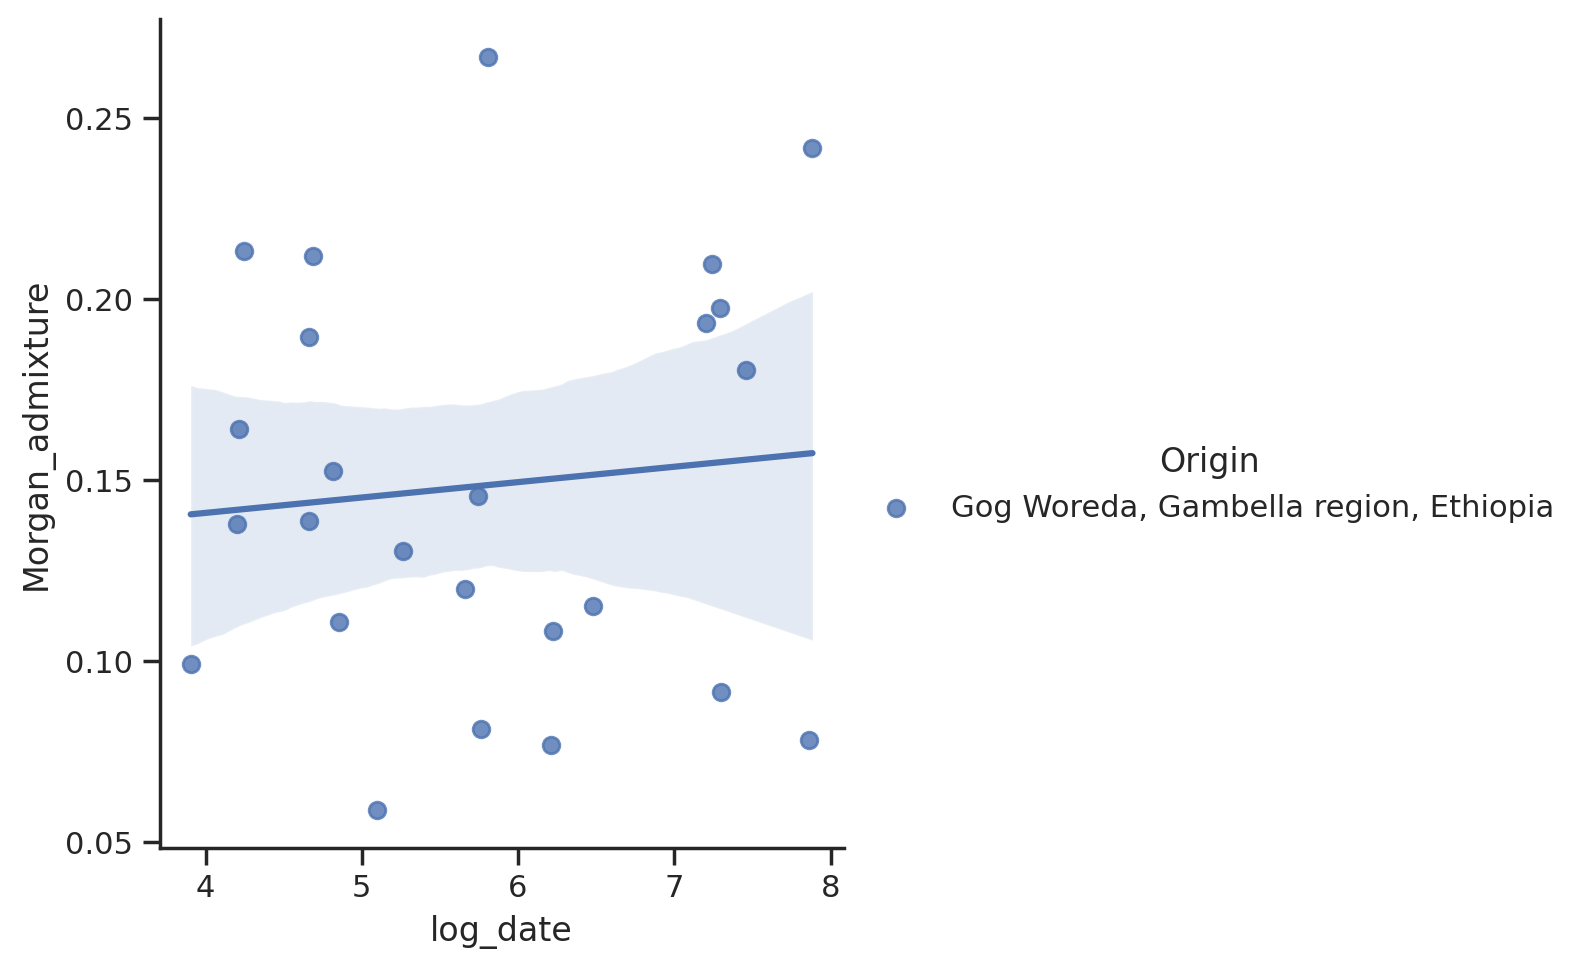

<Figure size 640x480 with 0 Axes>

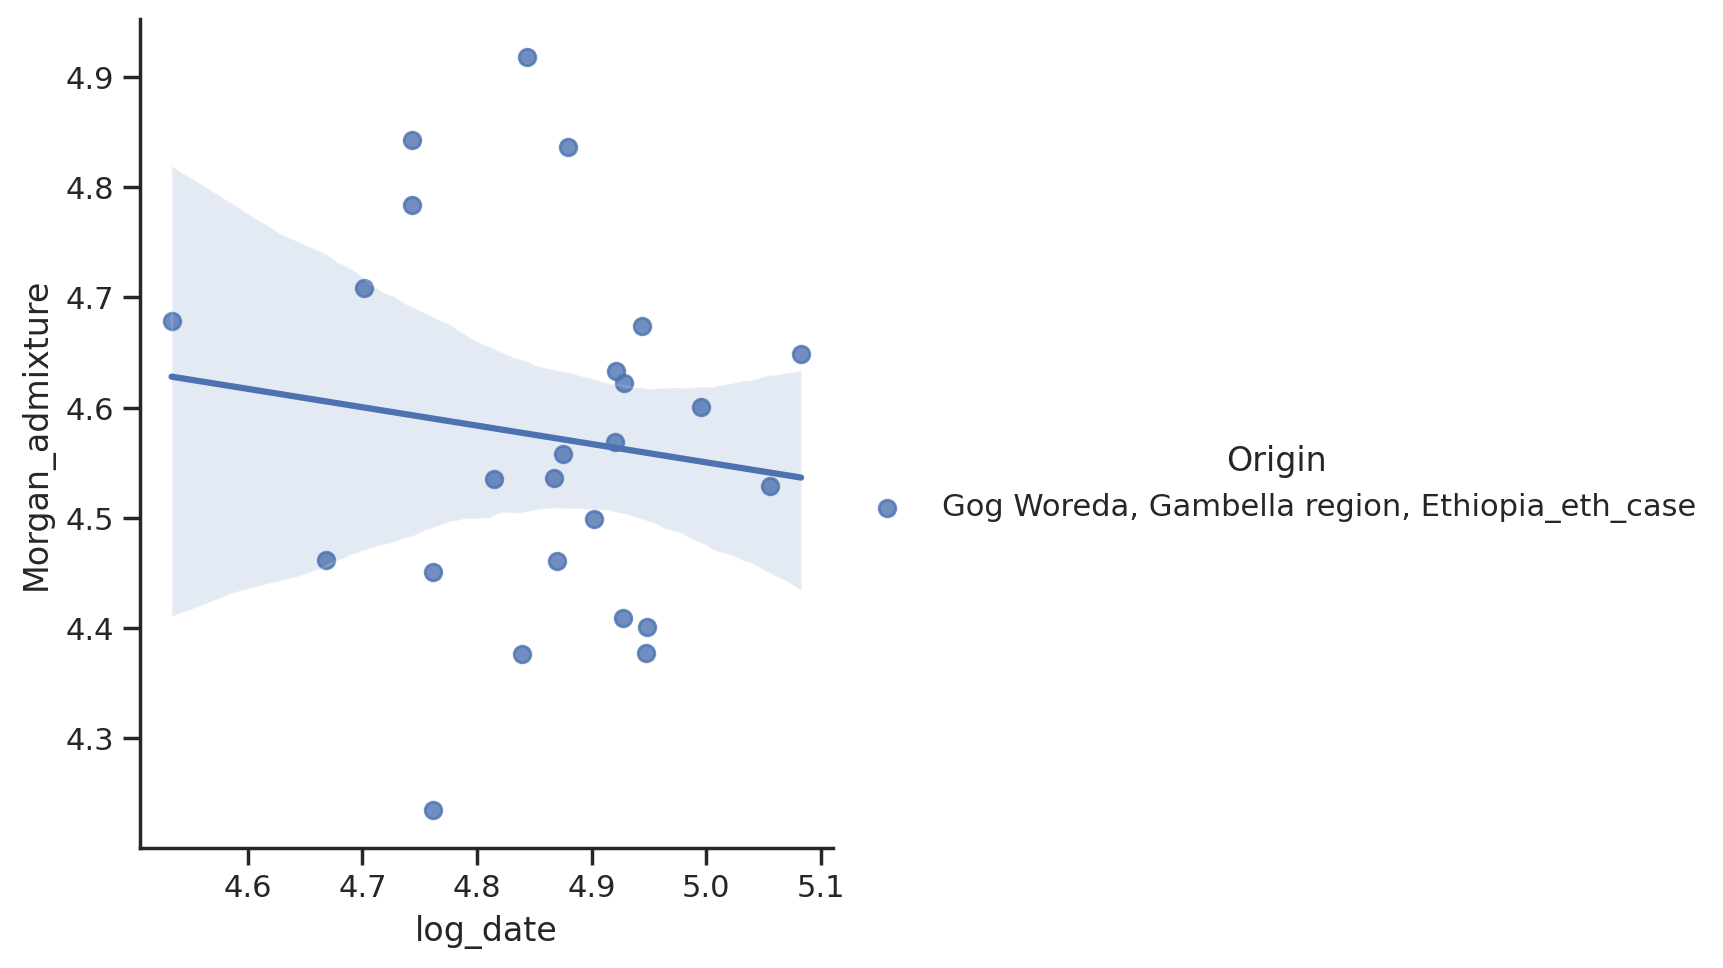

<Figure size 640x480 with 0 Axes>

In [21]:
for x in date_df.Origin.unique():
    sns.lmplot(data=date_df.loc[date_df.Origin == x], x="log_date", y="Morgan_admixture", hue="Origin")
    plt.figure()

In [22]:
ss_df.sort_values(by="length")

,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,start_cM,end,end_cM,Species,Origin,minor_parent_percentage,cM_length
24,22081483,22116588,35106,"Hamadryas, Ethiopia",1,PD_0744,0,chr19,44.594405,22116589,44.883296,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,0.288891
13,39306564,39345755,39192,"Hamadryas, Ethiopia",1,PD_0744,0,chr20,44.917324,39345756,45.179058,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,0.261734
39,55843681,55885146,41466,"Hamadryas, Ethiopia",1,PD_0744,0,chr3,65.981064,55885147,66.418112,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,0.437049
38,65976675,66022172,45498,"Hamadryas, Ethiopia",1,PD_0744,0,chr16,76.297016,66022173,76.743352,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,0.446336
44,162715989,162768075,52087,"Hamadryas, Ethiopia",1,PD_0744,0,chr7,139.154313,162768076,139.639525,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,0.485213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,35660668,37816218,2155551,"Hamadryas, Ethiopia",1,PD_0744,1,chr6,38.016373,37816219,39.526398,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,1.510026
16,48530122,50774717,2244596,"Hamadryas, Ethiopia",1,PD_0744,1,chr4,56.227301,50774718,57.430473,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,1.203172
4,39771161,42103043,2331883,"Hamadryas, Ethiopia",1,PD_0744,0,chr13,33.523641,42103044,34.750444,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,1.226803
34,109401736,111824850,2423115,"Hamadryas, Ethiopia",1,PD_0744,1,chr4,87.832775,111824851,89.413869,anubis,"Gog Woreda, Gambella region, Ethiopia_eth_case",1,1.581093


Intercept      0.554655
d           -130.542495
dtype: float64

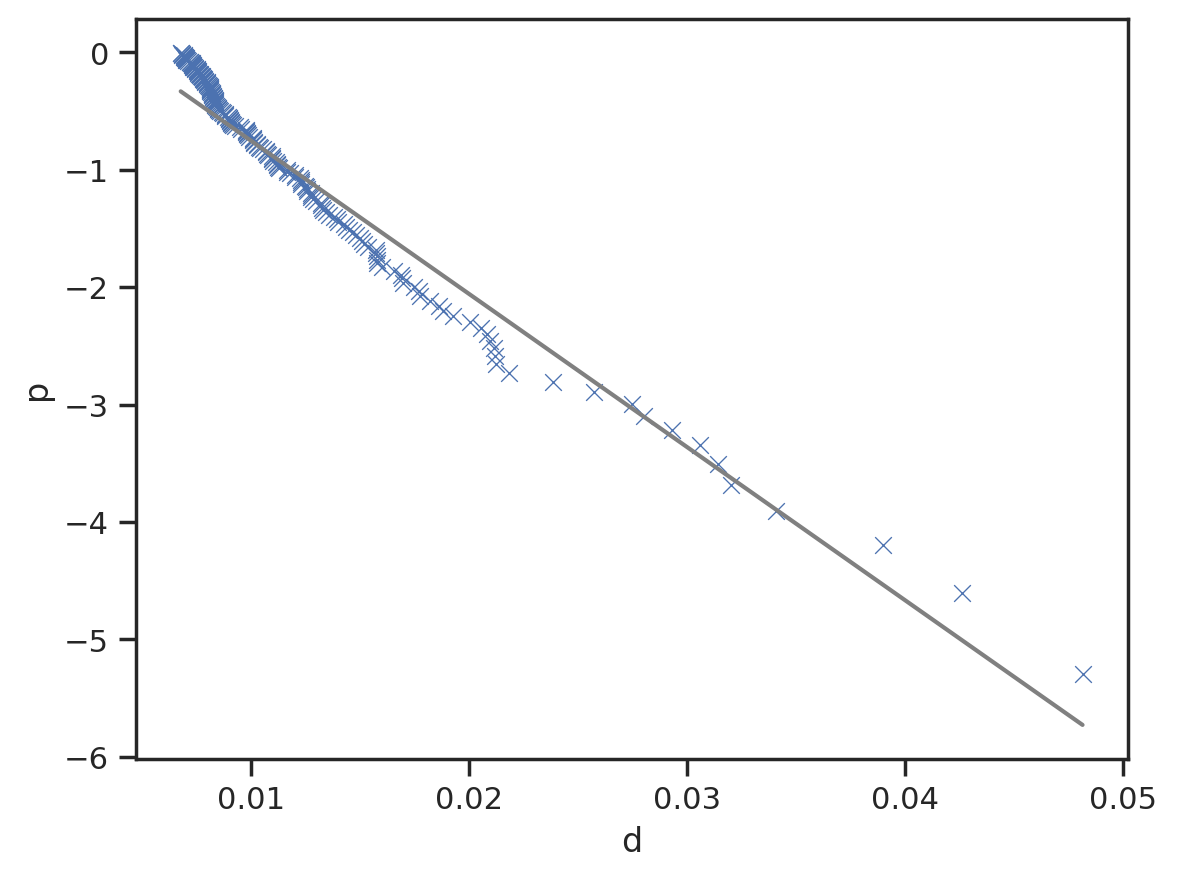

In [23]:
ax = sns.scatterplot(x=m_df.d, y=m_df.p, marker='x');
ax.plot(m_df.d, predicted_p, color='grey', marker=None);
results.params

<Axes: xlabel='cM_length', ylabel='Count'>

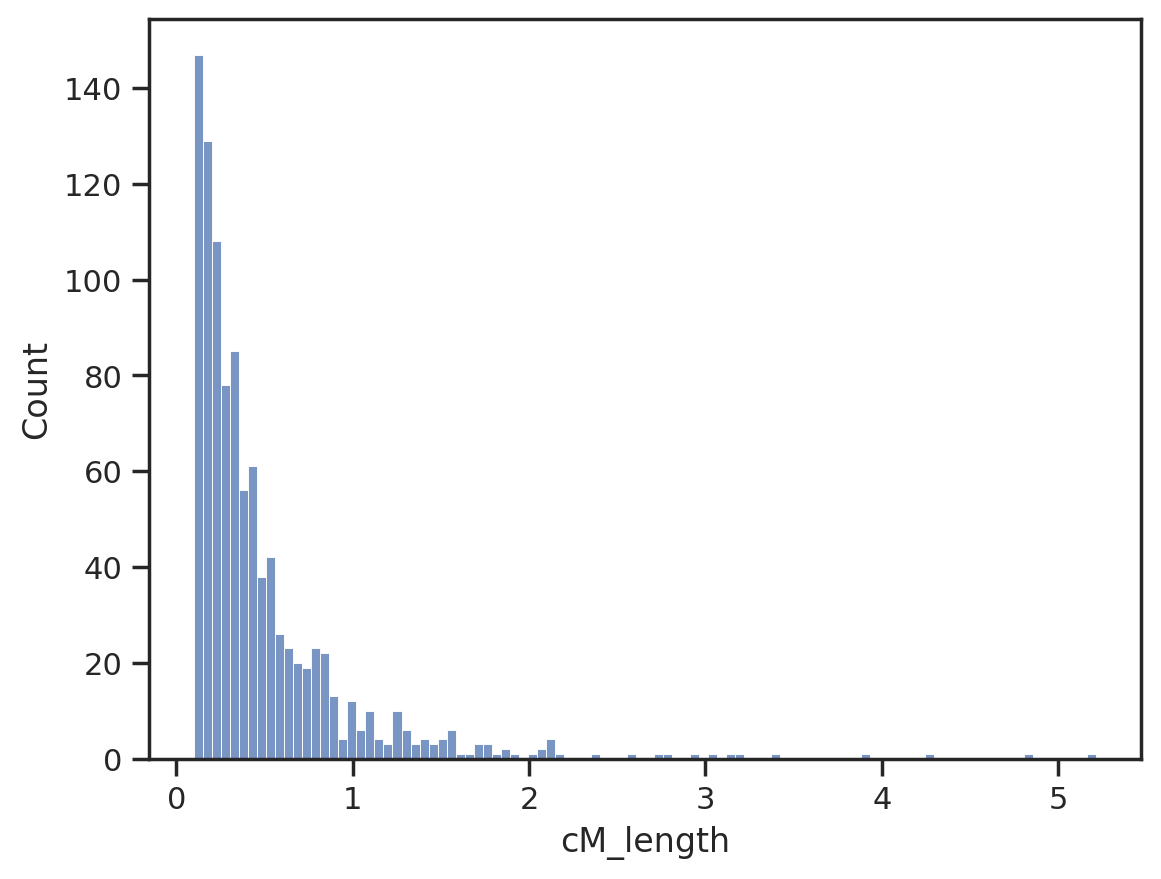

In [24]:
sns.histplot(ss_df.cM_length, bins=100)